##Importing Libraries

In [ ]:
!pip install feature_engine

In [214]:
import os
from pathlib import Path
import numpy as np
import pandas as pd
import warnings
import sklearn
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import chi2_contingency
from sklearn.model_selection import train_test_split
import missingno as mn
from sklearn.ensemble import IsolationForest,RandomForestRegressor



from sklearn.pipeline import(
  Pipeline,FeatureUnion)
from sklearn.compose import ColumnTransformer
from sklearn.impute import(
    SimpleImputer
)

from sklearn.preprocessing import(
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    FunctionTransformer,
    PowerTransformer,
    StandardScaler

)
from feature_engine.encoding import RareLabelEncoder
from feature_engine.datetime import DatetimeFeatures
from sklearn.metrics.pairwise import rbf_kernel
from feature_engine.outliers import Winsorizer
from feature_engine.selection import SelectBySingleFeaturePerformance


In [ ]:
pd.set_option("display.max_columns",None)
warnings.filterwarnings("ignore")
sklearn.set_config(transform_output="pandas")


In [211]:
train.select_dtypes(include="O").columns.tolist()

['airline', 'source', 'destination', 'total_stops', 'additional_info']

#Data Cleaning

##Initial_Analysis

In [ ]:
flights_df=pd.read_csv("/content/flight_price.csv")

In [ ]:
flights_df.head(10)

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302
5,SpiceJet,24/06/2019,Kolkata,Banglore,CCU → BLR,09:00,11:25,2h 25m,non-stop,No info,3873
6,Jet Airways,12/03/2019,Banglore,New Delhi,BLR → BOM → DEL,18:55,10:25 13 Mar,15h 30m,1 stop,In-flight meal not included,11087
7,Jet Airways,01/03/2019,Banglore,New Delhi,BLR → BOM → DEL,08:00,05:05 02 Mar,21h 5m,1 stop,No info,22270
8,Jet Airways,12/03/2019,Banglore,New Delhi,BLR → BOM → DEL,08:55,10:25 13 Mar,25h 30m,1 stop,In-flight meal not included,11087
9,Multiple carriers,27/05/2019,Delhi,Cochin,DEL → BOM → COK,11:25,19:15,7h 50m,1 stop,No info,8625


In [ ]:
flights_df.shape

(10683, 11)

In [ ]:
flights_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10683 entries, 0 to 10682
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   Airline          10683 non-null  object
 1   Date_of_Journey  10683 non-null  object
 2   Source           10683 non-null  object
 3   Destination      10683 non-null  object
 4   Route            10682 non-null  object
 5   Dep_Time         10683 non-null  object
 6   Arrival_Time     10683 non-null  object
 7   Duration         10683 non-null  object
 8   Total_Stops      10682 non-null  object
 9   Additional_Info  10683 non-null  object
 10  Price            10683 non-null  int64 
dtypes: int64(1), object(10)
memory usage: 918.2+ KB


In [ ]:
flights_df.dtypes

,0
Airline,object
Date_of_Journey,object
Source,object
Destination,object
Route,object
Dep_Time,object
Arrival_Time,object
Duration,object
Total_Stops,object
Additional_Info,object


In [ ]:
flights_df.duplicated().sum()

220

In [ ]:
flights_df.duplicated(keep=False).sum()

415

In [ ]:
flights_df[flights_df.duplicated(keep=False)].sort_values(by=["Airline","Date_of_Journey","Source","Destination","Dep_Time","Arrival_Time"])

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
6321,Air India,01/03/2019,Banglore,New Delhi,BLR → BOM → AMD → DEL,08:50,23:55 02 Mar,39h 5m,2 stops,No info,17135
9848,Air India,01/03/2019,Banglore,New Delhi,BLR → BOM → AMD → DEL,08:50,23:55 02 Mar,39h 5m,2 stops,No info,17135
572,Air India,03/03/2019,Banglore,New Delhi,BLR → DEL,21:10,23:55,2h 45m,non-stop,No info,7591
8168,Air India,03/03/2019,Banglore,New Delhi,BLR → DEL,21:10,23:55,2h 45m,non-stop,No info,7591
1495,Air India,1/04/2019,Kolkata,Banglore,CCU → DEL → COK → BLR,10:00,01:20 02 Apr,15h 20m,2 stops,No info,10408
...,...,...,...,...,...,...,...,...,...,...,...
2870,SpiceJet,24/03/2019,Banglore,New Delhi,BLR → DEL,05:45,08:35,2h 50m,non-stop,No check-in baggage included,4273
1535,SpiceJet,24/03/2019,Banglore,New Delhi,BLR → DEL,20:30,23:20,2h 50m,non-stop,No check-in baggage included,3873
3711,SpiceJet,24/03/2019,Banglore,New Delhi,BLR → DEL,20:30,23:20,2h 50m,non-stop,No check-in baggage included,3873
2634,Vistara,24/03/2019,Banglore,New Delhi,BLR → DEL,11:30,14:10,2h 40m,non-stop,No info,5403


**Initial Analysis-Observations**
              
  -Data types of features : `Date_of_Journey` , `Dep_Time`,`Arrival_Time` , `Duration` , `Total_Stops` need to be handled

  -Need to remove `220` duplicate samples

##Detailed Analysis

In [ ]:
flights_df.head()

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
0,IndiGo,24/03/2019,Banglore,New Delhi,BLR → DEL,22:20,01:10 22 Mar,2h 50m,non-stop,No info,3897
1,Air India,1/05/2019,Kolkata,Banglore,CCU → IXR → BBI → BLR,05:50,13:15,7h 25m,2 stops,No info,7662
2,Jet Airways,9/06/2019,Delhi,Cochin,DEL → LKO → BOM → COK,09:25,04:25 10 Jun,19h,2 stops,No info,13882
3,IndiGo,12/05/2019,Kolkata,Banglore,CCU → NAG → BLR,18:05,23:30,5h 25m,1 stop,No info,6218
4,IndiGo,01/03/2019,Banglore,New Delhi,BLR → NAG → DEL,16:50,21:35,4h 45m,1 stop,No info,13302


**Airline**

In [ ]:
flights_df["Airline"].value_counts()

,count
Airline,
Jet Airways,3849
IndiGo,2053
Air India,1752
Multiple carriers,1196
SpiceJet,818
Vistara,479
Air Asia,319
GoAir,194
Multiple carriers Premium economy,13


In [ ]:
flights_df.Airline.unique()

array(['IndiGo', 'Air India', 'Jet Airways', 'SpiceJet',
       'Multiple carriers', 'GoAir', 'Vistara', 'Air Asia',
       'Vistara Premium economy', 'Jet Airways Business',
       'Multiple carriers Premium economy', 'Trujet'], dtype=object)

In [ ]:
(
  flights_df
  .Airline
  .str.replace(" Premium economy","")
  .str.replace(" Business","")
  .str.title()
  .unique()
 )

array(['Indigo', 'Air India', 'Jet Airways', 'Spicejet',
       'Multiple Carriers', 'Goair', 'Vistara', 'Air Asia', 'Trujet'],
      dtype=object)

**Date_of_Journey**

In [ ]:
flights_df.Date_of_Journey

,Date_of_Journey
0,24/03/2019
1,1/05/2019
2,9/06/2019
3,12/05/2019
4,01/03/2019
...,...
10678,9/04/2019
10679,27/04/2019
10680,27/04/2019
10681,01/03/2019


In [ ]:
(
    flights_df
    .Date_of_Journey
    .loc[lambda ser:ser.str.contains("[^0-9/]")]
)

,Date_of_Journey


In [ ]:
(
 pd.to_datetime(flights_df.Date_of_Journey,dayfirst=True)


)

,Date_of_Journey
0,2019-03-24
1,2019-05-01
2,2019-06-09
3,2019-05-12
4,2019-03-01
...,...
10678,2019-04-09
10679,2019-04-27
10680,2019-04-27
10681,2019-03-01


**Source**

In [ ]:
flights_df.Source.unique()

array(['Banglore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

In [ ]:
(
    flights_df
    .Source
    .replace("Banglore","Bangalore")
    .unique()
)

array(['Bangalore', 'Kolkata', 'Delhi', 'Chennai', 'Mumbai'], dtype=object)

**Destination**

In [ ]:
flights_df.Destination.unique()

array(['New Delhi', 'Banglore', 'Cochin', 'Kolkata', 'Delhi', 'Hyderabad'],
      dtype=object)

In [ ]:
(
    flights_df
    .Destination
    .replace("Banglore","Bangalore")
    .replace("New Delhi","Delhi")
    .unique()
)

array(['Delhi', 'Bangalore', 'Cochin', 'Kolkata', 'Hyderabad'],
      dtype=object)

**Dep_Time**

In [ ]:
flights_df.Dep_Time

,Dep_Time
0,22:20
1,05:50
2,09:25
3,18:05
4,16:50
...,...
10678,19:55
10679,20:45
10680,08:20
10681,11:30


In [ ]:
(
    flights_df
    .Dep_Time
    .loc[lambda ser:ser.str.contains("[^0-9:]")]
)

,Dep_Time


In [ ]:
(
    pd.to_datetime(flights_df.Dep_Time).dt.time
)

,Dep_Time
0,22:20:00
1,05:50:00
2,09:25:00
3,18:05:00
4,16:50:00
...,...
10678,19:55:00
10679,20:45:00
10680,08:20:00
10681,11:30:00


**Arrival_Time**

In [ ]:
flights_df.Arrival_Time

,Arrival_Time
0,01:10 22 Mar
1,13:15
2,04:25 10 Jun
3,23:30
4,21:35
...,...
10678,22:25
10679,23:20
10680,11:20
10681,14:10


In [ ]:
(
    flights_df
    .Arrival_Time
    .loc[lambda ser:ser.str.contains("[^0-9:]")]
)

,Arrival_Time
0,01:10 22 Mar
2,04:25 10 Jun
6,10:25 13 Mar
7,05:05 02 Mar
8,10:25 13 Mar
...,...
10666,19:00 13 Jun
10667,20:20 13 Mar
10672,19:00 28 Jun
10673,04:25 28 May


In [ ]:
#checking any special characters are present in the values
(
    flights_df
    .Arrival_Time
    .str.split(" ",n=1)
    .str.get(1).unique()



)

array(['22 Mar', nan, '10 Jun', '13 Mar', '02 Mar', '10 May', '04 Mar',
       '13 Jun', '28 May', '19 Mar', '07 May', '02 Jun', '16 Jun',
       '19 May', '16 May', '28 Jun', '02 May', '28 Mar', '19 Jun',
       '04 Apr', '25 Mar', '07 Mar', '25 Jun', '07 Jun', '25 May',
       '13 May', '16 Mar', '22 May', '10 Apr', '04 Jun', '20 May',
       '28 Apr', '25 Apr', '10 Mar', '19 Apr', '13 Apr', '02 Apr',
       '23 Mar', '22 Apr', '11 May', '07 Apr', '03 May', '08 Mar',
       '03 Mar', '05 Mar', '22 Jun', '04 May', '26 May', '16 Apr',
       '26 Jun', '29 May', '29 Jun', '29 Mar', '23 May', '17 Jun'],
      dtype=object)

In [ ]:
pd.to_datetime(flights_df.Arrival_Time).dt.time

,Arrival_Time
0,01:10:00
1,13:15:00
2,04:25:00
3,23:30:00
4,21:35:00
...,...
10678,22:25:00
10679,23:20:00
10680,11:20:00
10681,14:10:00


**Duration**

In [ ]:
flights_df.Duration

,Duration
0,2h 50m
1,7h 25m
2,19h
3,5h 25m
4,4h 45m
...,...
10678,2h 30m
10679,2h 35m
10680,3h
10681,2h 40m


In [ ]:
(
    flights_df
    .Duration
    .loc[lambda ser:~ser.str.contains("h")]


)

,Duration
6474,5m


In [ ]:
flights_df.iloc[[6474]]

,Airline,Date_of_Journey,Source,Destination,Route,Dep_Time,Arrival_Time,Duration,Total_Stops,Additional_Info,Price
6474,Air India,6/03/2019,Mumbai,Hyderabad,BOM → GOI → PNQ → HYD,16:50,16:55,5m,2 stops,No info,17327


In [ ]:
(
    flights_df
    .Duration
    .str.replace("h","")
    .str.replace("m","")
    .str.split(" ",expand=True)
    .set_axis(["Hours","Minutes"],axis=1)
    .assign(
          Hours=lambda df_:(
                 df_
                 .Hours
                 .astype("int32")
                 .mul(60)),
          Minutes=lambda df_:(
                df_
                .Minutes
                .fillna("0")
                .astype("int32")),


    )
    .sum(axis=1)
    .to_frame()
    .join(flights_df.Duration)




)


,0,Duration
0,170,2h 50m
1,445,7h 25m
2,1140,19h
3,325,5h 25m
4,285,4h 45m
...,...,...
10678,150,2h 30m
10679,155,2h 35m
10680,180,3h
10681,160,2h 40m


**total_stops**

In [ ]:
flights_df.Total_Stops.unique()

array(['non-stop', '2 stops', '1 stop', '3 stops', nan, '4 stops'],
      dtype=object)

In [ ]:
(
    flights_df
    .Total_Stops
    .replace("non-stop","0")
    .str.replace(" stops?","",regex=True)
    .pipe(lambda ser:pd.to_numeric(ser))

)

,Total_Stops
0,0.0
1,2.0
2,2.0
3,1.0
4,1.0
...,...
10678,0.0
10679,0.0
10680,0.0
10681,0.0


**Additional_Info**

In [ ]:
flights_df.Additional_Info.unique()

array(['No info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover', 'No Info',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

In [ ]:
(
    flights_df
    .Additional_Info
    .replace("No info","No Info")
    .unique()
)

array(['No Info', 'In-flight meal not included',
       'No check-in baggage included', '1 Short layover',
       '1 Long layover', 'Change airports', 'Business class',
       'Red-eye flight', '2 Long layover'], dtype=object)

**Observations**

  -`Airline` feature has similair categories like `Jet Airways` & `Jet Airways Business` need to handle it

  -Spelling Mistakes in `Source` and `Destination` need to handle it
  
  -`Route` feature is similair to source and destination,to avoid
    redundancy remove route feature

  -Data types of `date_of_journey` ,`dep_time` ,`arrival_time` need to be changed

  -`Duration` feature is mix of hours and minutes need to convert it into either hours or minutes

  -`total_stops` data type  is mixed

  -mistakes in `additional_info` feature values


##Cleaning Operation

In [ ]:
def clean_data(df):
     return(
              df
              .drop_duplicates()
              .drop(index=[6474])
              .assign(**{
                            col:df[col].str.strip()
                            for col in df.select_dtypes(include="O")
                        })
              .rename(columns=str.lower)
              .assign(
                  airline=lambda df_:
                  (
                       df_
                       .airline
                       .str.replace(" Premium economy","")
                       .str.replace(" Business","")
                       .str.title()

                 ),
                 date_of_journey=lambda df_ :pd.to_datetime(df_.date_of_journey,dayfirst=True,format="mixed"),
                 source=lambda df_:df_.source.replace("Banglore","Bangalore"),
                 destination=lambda df_:df_.destination.replace("Banglore","Bangalore").replace("New Delhi","Delhi"),
                 dep_time=lambda df_ :pd.to_datetime(df_.dep_time,format="mixed"),
                 arrival_time=lambda df_ :pd.to_datetime(df_.arrival_time,format="mixed"),
                 duration=lambda df1:
                  (
                       df1
                      .duration
                      .str.split(" ",expand=True)
                      .set_axis(["Hours","Minutes"],axis=1)
                      .assign(
                            Hours=lambda df_:(
                                  df_
                                  .Hours
                                  .str.replace("h","")
                                  .astype("int32")
                                  .mul(60)),
                            Minutes=lambda df_:(
                                  df_
                                  .Minutes
                                  .str.replace("m","")
                                  .fillna("0")
                                  .astype("int32")),
                            )
                     .sum(axis=1)
                     .astype("int32")
                  ),
                  total_stops=lambda df_:(
                       df_
                      .total_stops
                      .replace("non-stop","0")
                      .str.replace(" stops?","",regex=True)
                      #.pipe(lambda ser:pd.to_numeric(ser))
                   ),
                  additional_info=lambda df_: (
                  df_
                  .additional_info
                  .replace("No info","No Info")))
              .drop(columns=["route"])
              )



In [ ]:
flights_cleaned=clean_data(flights_df)

In [ ]:
flights_cleaned.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
0,Indigo,2019-03-24,Bangalore,Delhi,2024-12-03 22:20:00,2024-03-22 01:10:00,170,0,No Info,3897
1,Air India,2019-05-01,Kolkata,Bangalore,2024-12-03 05:50:00,2024-12-03 13:15:00,445,2,No Info,7662
2,Jet Airways,2019-06-09,Delhi,Cochin,2024-12-03 09:25:00,2024-06-10 04:25:00,1140,2,No Info,13882
3,Indigo,2019-05-12,Kolkata,Bangalore,2024-12-03 18:05:00,2024-12-03 23:30:00,325,1,No Info,6218
4,Indigo,2019-03-01,Bangalore,Delhi,2024-12-03 16:50:00,2024-12-03 21:35:00,285,1,No Info,13302


In [ ]:
flights_cleaned.dtypes

,0
airline,object
date_of_journey,datetime64[ns]
source,object
destination,object
dep_time,datetime64[ns]
arrival_time,datetime64[ns]
duration,int32
total_stops,object
additional_info,object
price,int64


##Splitting Data

In [ ]:
X=flights_cleaned.drop(columns="price")
Y=flights_cleaned.price.copy()

In [ ]:
X_,X_test,Y_,Y_test=train_test_split(X,Y,test_size=0.2,random_state=34)

In [ ]:
X_train,X_val,Y_train,Y_val=train_test_split(X_,Y_,test_size=0.2,random_state=34)

In [ ]:
print("X Train:",X_train.shape)
print("Y Train:",Y_train.shape)
print("X Val:",X_val.shape)
print("Y Val:",Y_val.shape)
print("X Test:",X_test.shape)
print("Y Test:",Y_test.shape)

X Train: (6695, 9)
Y Train: (6695,)
X Val: (1674, 9)
Y Val: (1674,)
X Test: (2093, 9)
Y Test: (2093,)


In [ ]:
X_train.join(Y_train).to_csv("train.csv",index=False)
X_val.join(Y_val).to_csv("val.csv",index=False)
X_test.join(Y_test).to_csv("test.csv",index=False)

In [ ]:
X_train

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info
9905,Spicejet,2019-06-21,Bangalore,Delhi,2024-12-03 21:10:00,2024-06-22 00:05:00,175,0,No check-in baggage included
190,Indigo,2019-03-03,Bangalore,Delhi,2024-12-03 12:10:00,2024-12-03 17:05:00,295,1,No Info
7832,Indigo,2019-06-09,Chennai,Kolkata,2024-12-03 13:15:00,2024-12-03 15:35:00,140,0,No Info
1914,Jet Airways,2019-05-21,Kolkata,Bangalore,2024-12-03 08:25:00,2024-12-03 19:50:00,685,1,No Info
9085,Spicejet,2019-04-06,Kolkata,Bangalore,2024-12-03 06:55:00,2024-12-03 09:30:00,155,0,No check-in baggage included
...,...,...,...,...,...,...,...,...,...
6021,Indigo,2019-06-01,Bangalore,Delhi,2024-12-03 13:00:00,2024-12-03 15:50:00,170,0,No Info
2663,Spicejet,2019-04-21,Kolkata,Bangalore,2024-12-03 06:55:00,2024-12-03 09:30:00,155,0,No Info
824,Air India,2019-03-03,Delhi,Cochin,2024-12-03 18:05:00,2024-12-03 21:10:00,185,0,No Info
9158,Jet Airways,2019-06-03,Delhi,Cochin,2024-12-03 18:25:00,2024-06-04 12:35:00,1090,2,No Info


#EDA

##Initial Summary

In [ ]:
train=X_train.join(Y_train)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6695 entries, 9905 to 7941
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   airline          6695 non-null   object        
 1   date_of_journey  6695 non-null   datetime64[ns]
 2   source           6695 non-null   object        
 3   destination      6695 non-null   object        
 4   dep_time         6695 non-null   datetime64[ns]
 5   arrival_time     6695 non-null   datetime64[ns]
 6   duration         6695 non-null   int32         
 7   total_stops      6695 non-null   object        
 8   additional_info  6695 non-null   object        
 9   price            6695 non-null   int64         
dtypes: datetime64[ns](3), int32(1), int64(1), object(5)
memory usage: 807.2+ KB


In [ ]:
train.describe(include="number").T

,count,mean,std,min,25%,50%,75%,max
duration,6695.0,628.411501,503.113488,75.0,170.0,500.0,910.0,2860.0
price,6695.0,9019.835848,4579.580598,1759.0,5228.0,8309.0,12284.0,62427.0


In [ ]:

(
  train
  .drop(columns=["dep_time","arrival_time"])
  .describe(include="O").T
)

,count,unique,top,freq
airline,6695,9,Jet Airways,2386
source,6695,5,Delhi,2759
destination,6695,5,Cochin,2759
total_stops,6695,5,1,3586
additional_info,6695,9,No Info,5242


 **Initial Observations**

  -`0` Missing Values in the Training Data

  -`98%` of flights duration is between `120` minutes and `1120`minutes

  -Most of the flights are Jet Airways

  -Most of the flights are travelling from Delhi

  -Most of the flights are travelled to Cochin



##Handling Missing Data

In [ ]:
train.isna().sum()

,0
airline,0
date_of_journey,0
source,0
destination,0
dep_time,0
arrival_time,0
duration,0
total_stops,0
additional_info,0
price,0


##Handling Outliers

In [ ]:
iso_forest=IsolationForest()

(
    train
    .assign(
        is_outlier=iso_forest.fit_predict(train
                                          .drop(columns="price")
                                          .select_dtypes(include="number")
                                        ))
    .query("is_outlier==-1")
    .duration
    .describe(include="number")

)


,duration
count,2443.000000
mean,1052.095784
std,555.913124
min,75.000000
25%,830.000000
50%,1145.000000
75%,1475.000000
max,2860.000000


**Observations**

  -`2811` outliers lies in training data

  -Normal samples duration mostly lies between 180minutes and 670 minutes
  
  -whereas ouliers duration lies between 300minutes and 1500minutes

  -highest duration of normal samples is the average of the outliers,these are truly outliers no randomness

##Correlation Analysis - Strength of Association

**Correlation between Numerical Features**

In [ ]:
corr=train.corr(numeric_only=True)
mask=np.zeros_like(corr,dtype=bool)
mask[np.triu_indices_from(mask)]=True

<Axes: >

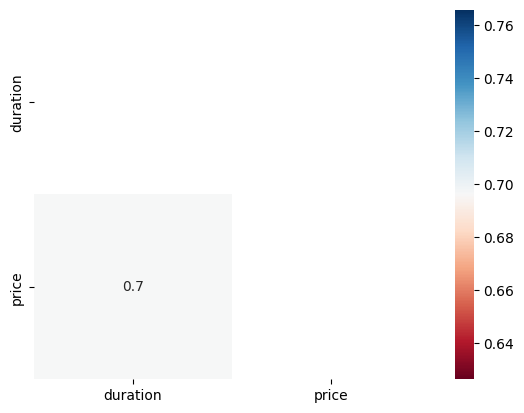

In [ ]:
#Between numerical features
sns.heatmap(train.corr(numeric_only=True,method="spearman"),cmap='RdBu',annot=True,mask=mask)

<Figure size 2000x1200 with 0 Axes>

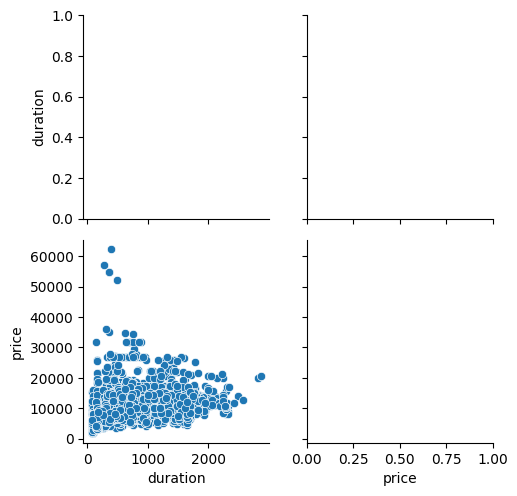

In [ ]:
plt.figure(figsize=(20,12))
g=sns.PairGrid(train)
g.map_lower(sns.scatterplot)
#sns.

**Correlation between Categorical features**

In [ ]:
cat_columns=[col for col in train.drop(columns=["price","dep_time","arrival_time"]).columns if train[col].dtype=="O"]

In [ ]:
def cat_correlation_heatmap(data):
        cat_columns=[col for col in data.drop(columns=["price","dep_time","arrival_time"]).columns if data[col].dtype=="O"]
        corr_matrix=np.ones((len(cat_columns),len(cat_columns)))
        for i,col1 in enumerate(cat_columns):
          for j,col2 in enumerate(cat_columns):
            if col1!=col2:
              cont_table=pd.crosstab(data[col1],data[col2])
              chi2,p,dof,exp=chi2_contingency(cont_table)
              n=cont_table.values.sum()
              k=min(cont_table.shape)
              cramers_v=np.sqrt(chi2/(n*(k-1)))
              corr_matrix[i][j]=cramers_v
        mask=np.zeros_like(corr_matrix,dtype=bool)
        mask[np.triu_indices_from(mask)]=True
        sns.heatmap(corr_matrix,annot=True,mask=mask,cmap="RdBu",xticklabels=cat_columns,yticklabels=cat_columns)


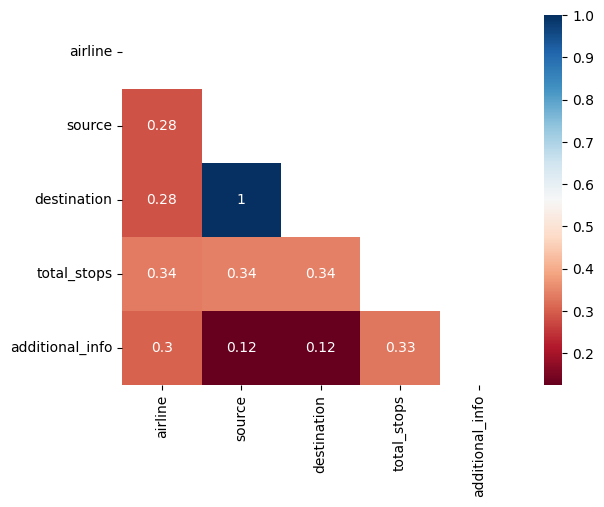

In [ ]:
cat_correlation_heatmap(train)

**Observations**

 -`Price` is slightly Associated(Positive Correlation) with the `Duration`

 -No Multicollinearity as single numerical feature present in data

 -categorical features are not highly correlated with each other ,no multicollinearity and no redundant features present in the data

 -only source and destination has correlation 1,there might be for each source only single destination and viceversa

##Deatiled Analysis

In [ ]:
train.dtypes

,0
airline,object
date_of_journey,datetime64[ns]
source,object
destination,object
dep_time,datetime64[ns]
arrival_time,datetime64[ns]
duration,int32
total_stops,object
additional_info,object
price,int64


### Custom EDA Class

In [ ]:
class EDA:
        import scipy.stats as st
        import statsmodels.api as sm
        from rich.console import Console
        from rich.panel import Panel
        from rich.align import Align
        console=Console()

        def __init__(self):
                 import warnings
                 warnings.filterwarnings("ignore")


        def cat_info(self,df,col):

          self.console.print(self.Panel("Data",expand=False))
          print(df[col])

          print()
          (
          self.console.print(self.Panel("Description",expand=False)),
          print(
              df[col]
              .describe()
              .to_frame()

          ))


          n=df[col].nunique(),
          miss_no=df[col].isna().sum(),
          miss_per=(df[col].isna().mean())*100

          (
          print(),
          self.console.print(self.Panel("Missing Values Information",expand=False)),
          print("Missing values count:",miss_no[0],"\n"),
          print("Missing values Percentage:",miss_per,"\n"),
          )

          (
          self.console.print(self.Panel("Frequency count of each category",expand=False)),

          print( df[col]
              .value_counts()
              .to_frame()
              .set_axis(["Count"],axis=1)
              .assign(percentages=lambda df_:
                      round((df_["Count"]/df_["Count"].values.sum())*100,2))
          ),
          )


        def num_info(self,df,col):

          self.console.print(self.Panel("Data",expand=False))
          print(df[col])

          print()
          (
          self.console.print(self.Panel("Description",expand=False)),
          print(
              df[col]
              .describe()
              .to_frame()

          ))


          n=df[col].nunique(),
          miss_no=df[col].isna().sum(),
          miss_per=(df[col].isna().mean())*100

          (
          print(),
          self.console.print(self.Panel("Missing Values Information",expand=False)),
          print("Missing values count:",miss_no[0],"\n"),
          print("Missing values Percentage:",miss_per,"\n"),
          )

          (
           print("\n\nSkewness:",self.st.skew(df[col])),
           print("\n"),
           print("Kurtosis:",self.st.kurtosis(df[col]))
          )



        def cat_univar_plots(self,df,col):
          fig,axes=plt.subplots(1,2,figsize=(15,6))
          fig.suptitle(f"Univariate analysis of {col.upper()} feature",fontsize=16, fontweight="bold")
          #countplot
          (
          sns.countplot(data=df,x=col,ax=axes[0]),
          axes[0].set_xticklabels(axes[0].get_xticklabels(),rotation=30,ha="right"),
          axes[0].set_title("Count Plot"),
          axes[0].set_xlabel(f"{col}"),
          axes[0].set_ylabel("count"),


          )

          #piechart
          (
              counts:=df[col].value_counts(),
              labels:=counts.index,
              percentages:=[f"{label}-{(count/counts.sum())*100:.1f}%" for label,count in zip(labels,list(counts))],
              axes[1].pie(counts, startangle=90),
              plt.legend(labels=percentages,loc="upper left",bbox_to_anchor=(1, 1)),
              axes[1].set_title("Pie Chart")

          )
          plt.show()

        def cat_num_bivar_plots(self,df,cat_var,num_var,hue=None):
          fig,axes=plt.subplots(2,2,figsize=(15,10),sharey=True)
          fig.suptitle(f"Bivariate Analysis of {cat_var} feature",fontsize=16,fontweight="bold")

          #barplot
          (
              sns.barplot(data=df,x=cat_var,y=num_var,ax=axes[0][0],hue=hue),
              axes[0][0].set_title("Bar Plot"),
              axes[0][0].set_xlabel(f"{cat_var}"),
              axes[0][0].set_ylabel(f"{num_var}(AVG)"),
              axes[0][0].set_xticklabels(axes[0][0].get_xticklabels(),rotation=25,ha="right"),
              plt.subplots_adjust(hspace=0.6)


          )

          #boxplot

          (
              sns.boxplot(data=df,x=cat_var,y=num_var,ax=axes[0][1]),
              axes[0][1].set_xticklabels(axes[0][1].get_xticklabels(),rotation=25,ha="right"),
              axes[0][1].set_title("Box Plot"),
              axes[0][1].set_xlabel(cat_var),
              axes[0][1].set_ylabel(num_var)

          )

          #violinplot
          (
              sns.violinplot(data=df,x=cat_var,y=num_var,ax=axes[1][0]),
              axes[1][0].set_title("Violin Plot"),
              axes[1][0].set_xticklabels(axes[1][0].get_xticklabels(),rotation=25,ha="right"),
              axes[1][0].set_xlabel(cat_var),
              axes[1][0].set_ylabel(num_var)

          )

          #stripplot
          (
              sns.stripplot(data=df,x=cat_var,y=num_var,ax=axes[1][1]),
              axes[1][1].set_title("Violin Plot"),
              axes[1][1].set_xticklabels(axes[1][1].get_xticklabels(),rotation=25,ha="right"),
              axes[1][1].set_xlabel(cat_var),
              axes[1][1].set_ylabel(num_var)

          )
          plt.show()


        def cat_num_hypothesis_testing(self,df,cat_var,num_var,alpha=0.05):

              categories=list(df[cat_var].unique())
              groups=[list(group[num_var].values) for name,group in df.groupby(cat_var)]

              #onewayanova
              self.console.print(self.Panel("ONE WAY ANOVA TEST\n",expand=False))
              f_statistic,p_value=self.st.f_oneway(*groups)
              print("Null Hypothesis:means of groups are equal\n")
              print("Alternative Hypothesis:means of groups are not equal\n")
              if p_value<=alpha:
                print(f"Result: We have enough evidence to reject null hypothesis-> {cat_var} and {num_var} are associated with each other at {alpha*100}% significance level")
              else:
                print(f"Result: We Failed(not have enough evidence) to reject null hypothesis-> {cat_var} and {num_var} are not associated with each other at {alpha*100}% significance level")

              #kruskal wallis test
              print("\n\n")
              self.console.print(self.Panel("Kruskal Wallis TEST\n",expand=False))
              f_statistic,p_value=self.st.kruskal(*groups)
              print("Null Hypothesis:means of groups are equal\n")
              print("Alternative Hypothesis:means of groups are not equal\n")
              if p_value<=alpha:
                print(f"Result: We have enough evidence to reject null hypothesis-> {cat_var} and {num_var} are associated with each other at {alpha*100}% significance level")
              else:
                print(f"Result: We Failed(not have enough evidence) to reject null hypothesis-> {cat_var} and {num_var} are not associated with each other at {alpha*100}% significance level")


        def num_univar_plots(self,df,num_var,stat="count"):
            fig,axes=plt.subplots(2,2,figsize=(15,10),sharey=True)
            fig.suptitle(f"Univariate Analysis of {num_var} feature")

            #histogram
            sns.histplot(data=df,x=num_var,bins="auto",ax=axes[0][0],stat="count")
            axes[0][0].set_title("Hist Plot")
            axes[0][0].set_xlabel(f"{num_var}")
            axes[0][0].set_ylabel(f"{stat}")




            #kdeplot
            sns.kdeplot(data=train,x=num_var,ax=axes[0][1])
            #sns.rugplot(data=train,x=num_var,ax=axes[0][1])
            axes[0][1].set_title("KDE Plot")
            axes[0][1].set_xlabel(f"{num_var}")
            #axes[0][1].set_ylabel(f"{stat}")

            #boxplot
            sns.boxplot(data=train,x=num_var,ax=axes[1][0])
            axes[1][0].set_title("Box Plot")
            axes[1][0].set_xlabel(f"{num_var}")
            #axes[1][0].set_ylabel(f"{stat}")

            #QQplot
            self.sm.qqplot(df[num_var],line='45',ax=axes[1][1])
            axes[1][1].set_title("QQ Plot")
            axes[1][1].set_xlabel(f"{num_var}")
            #axes[1][1].set_ylabel(f"{stat}")

            plt.tight_layout()
            plt.show()












        def num_normality_test(self,df,col,alpha=0.05):

          #shapiro test
          self.console.print(self.Panel("Shapiro-Wilk Test",expand=False))
          stat,p_value=self.st.shapiro(df[col].values.tolist())
          print("Null Hypothesis: Data is normally distributed\n")
          print("Alternative Hypothesis: Data is not normally distributed\n")
          if p_value<=alpha:
            print(f"Result: We have enough evidence to reject null hypothesis-> Data does not appears to be normally distributed at {alpha*100}% significance level")
          else:
            print(f"Result: We failed(not have enough evidence) to reject null hypothesis-> Data appears to be normally distributed at {alpha*100}% significance level")

        #Anderson darling test
          print("\n\n")
          self.console.print(self.Panel("Anderson-Darling Test",expand=False))
          result=self.st.anderson(df[col].values.tolist(),dist="norm")
          print("Null Hypothesis: Data fits the specified distribution\n")
          print("Alternative Hypothesis: Data does not fits specified distribution\n")
          for crit_val,sig_level in zip(result.critical_values,result.significance_level):
              if result.statistic<=crit_val:
                print(f"Result: We failed(does have enough evidence) to reject null hypothesis-> Data appears to be normally distributed at {sig_level}% significance level")
              else:
                print(f"Result:We have enough evidence to reject null hypothesis-> Data does not appears to be normally distributed at {sig_level}% significance level")

        def num_num_hypothesis_testing(self,df,num_var1,num_var2,alpha=0.05):

          #Pearson’s Correlation
          self.console.print(self.Panel("Pearson’s Correlation",expand=False))
          stat,p_value=self.st.pearsonr(df[num_var1].values.tolist(),df[num_var2].values.tolist())
          print("Null Hypothesis: No linear Correlation between variables\n")
          print("Alternative Hypothesis: Linear Correlation between variables\n")
          if p_value<=alpha:
            print(f"Result: We have enough evidence to reject null hypothesis-> Linear Correlation between variables {num_var1} and {num_var2} at {alpha*100}% significance level")
          else:
            print(f"Result: We failed(not have enough evidence) to reject null hypothesis-> No linear Correlation between variables {num_var1} and {num_var2} at {alpha*100}% significance level")


          #Spearman’s Rank Correlation
          print("\n\n")
          self.console.print(self.Panel("Spearman’s Rank Correlation",expand=False))
          stat,p_value=self.st.spearmanr(df[num_var1].values.tolist(),df[num_var2].values.tolist())
          print("Null Hypothesis: No Monotonic Correlation between variables\n")
          print("Alternative Hypothesis: Monotonic Correlation between variables\n")
          if p_value<=alpha:
            print(f"Result: We have enough evidence to reject null hypothesis-> Monotonic Correlation between variables {num_var1} and {num_var2} at {alpha*100}% significance level")
          else:
            print(f"Result: We failed(not have enough evidence) to reject null hypothesis-> No Monotonic Correlation between variables {num_var1} and {num_var2} at {alpha*100}% significance level")


















eda=EDA()

<Axes: xlabel='duration', ylabel='Density'>

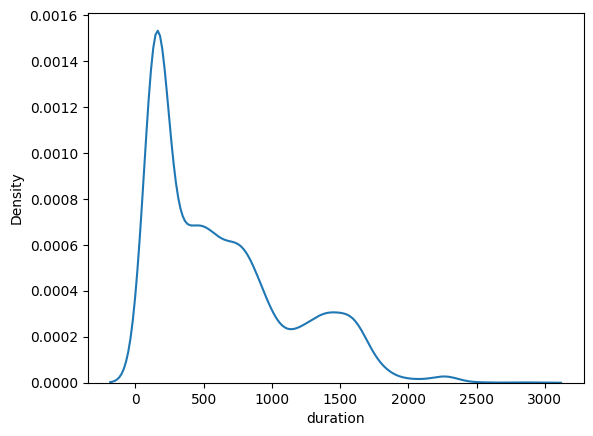

In [ ]:
sns.kdeplot(data=train,x="duration")

###Airline

In [ ]:
eda.cat_info(train,"airline")

╭──────╮
│ Data │
╰──────╯

9905       Spicejet
190          Indigo
7832         Indigo
1914    Jet Airways
9085       Spicejet
           ...     
6021         Indigo
2663       Spicejet
824       Air India
9158    Jet Airways
7941    Jet Airways
Name: airline, Length: 6695, dtype: object



╭─────────────╮
│ Description │
╰─────────────╯

            airline
count          6695
unique            9
top     Jet Airways
freq           2386



╭────────────────────────────╮
│ Missing Values Information │
╰────────────────────────────╯

Missing values count: 0 

Missing values Percentage: 0.0 



╭──────────────────────────────────╮
│ Frequency count of each category │
╰──────────────────────────────────╯

                   Count  percentages
airline                              
Jet Airways         2386        35.64
Indigo              1296        19.36
Air India           1064        15.89
Multiple Carriers    767        11.46
Spicejet             513         7.66
Vistara              323         4.82
Air Asia             220         3.29
Goair                125         1.87
Trujet                 1         0.01


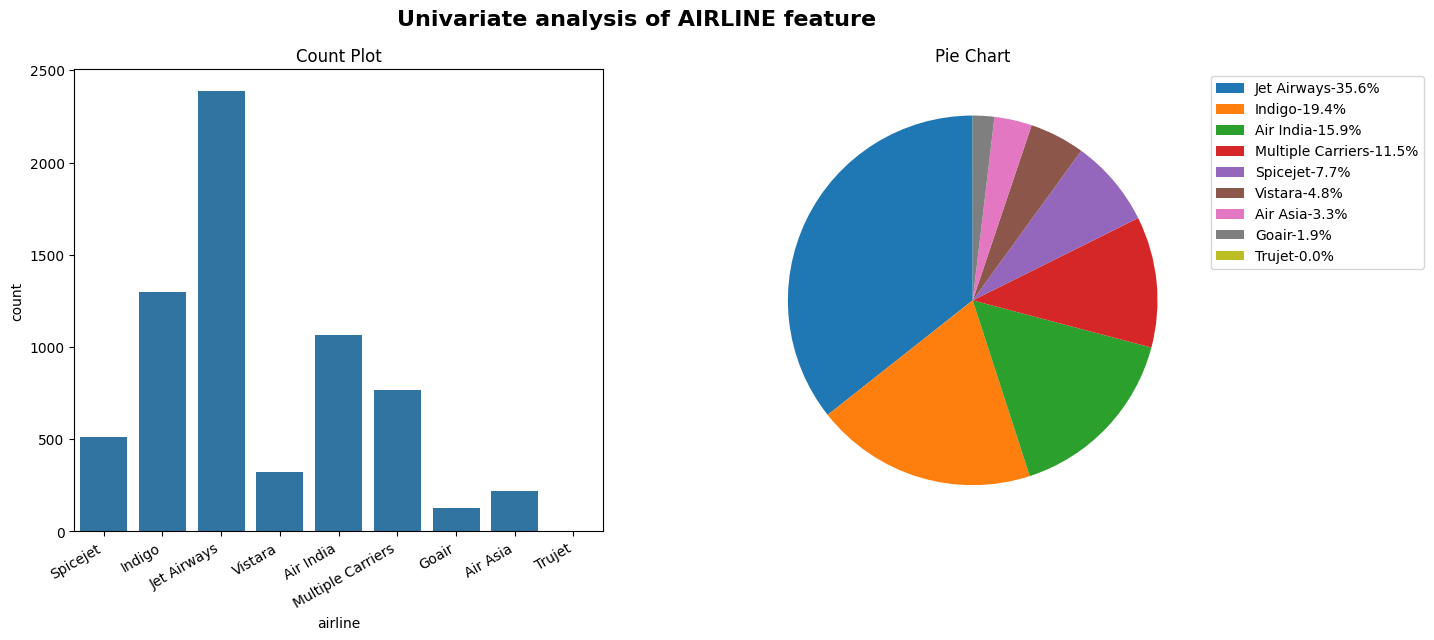

In [ ]:
eda.cat_univar_plots(train,"airline")

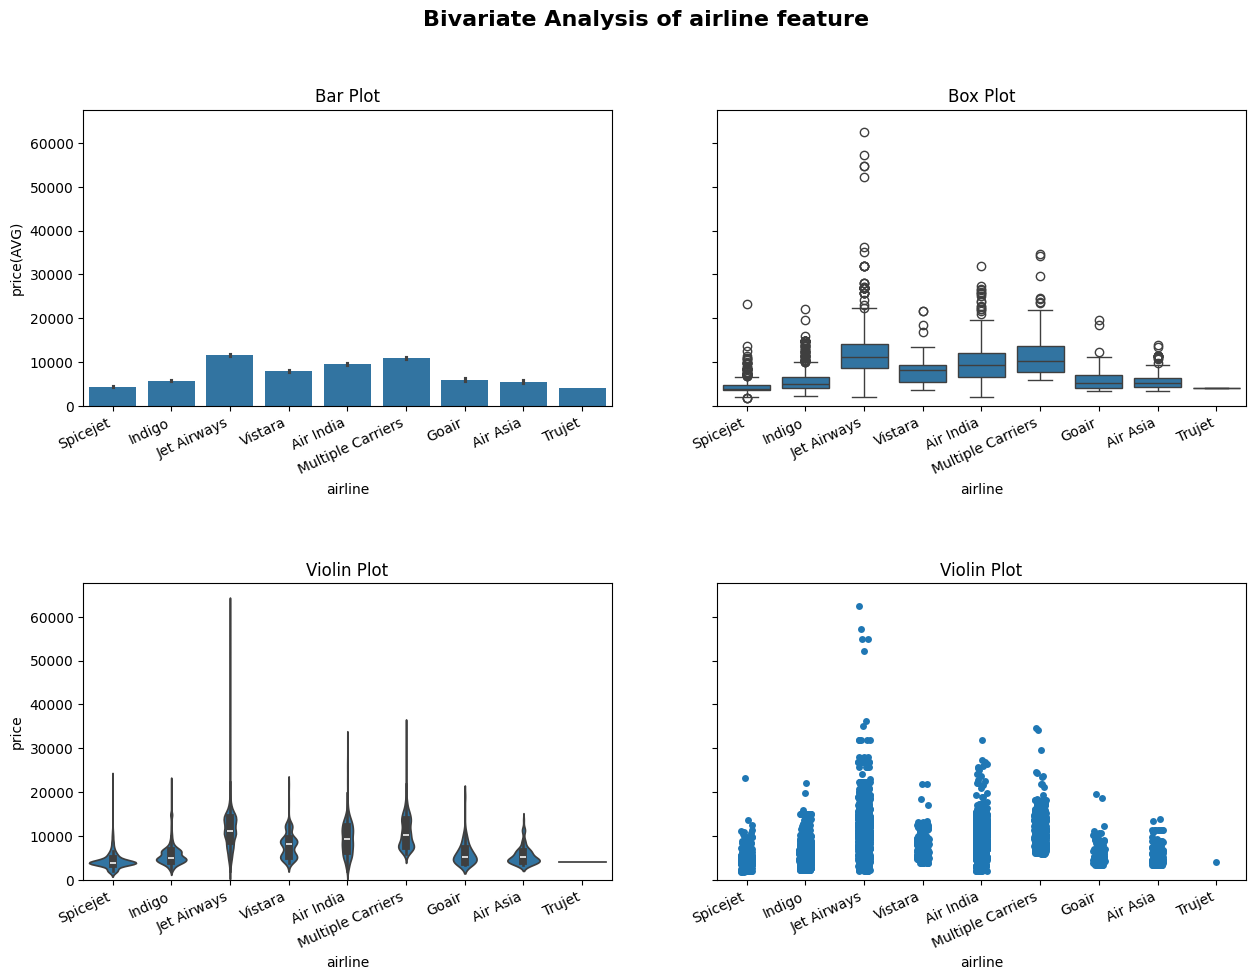

In [ ]:
eda.cat_num_bivar_plots(train,"airline","price")

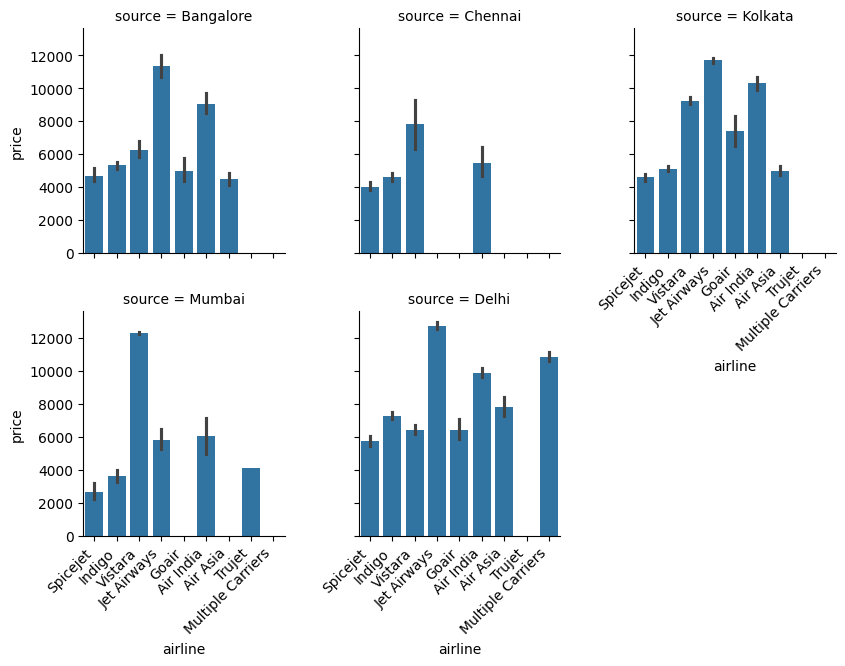

In [ ]:
fg=sns.FacetGrid(train,col="source",col_wrap=3)
fg.map(sns.barplot,"airline","price")
for ax in fg.axes[2:]:
      ax.set_xticklabels(ax.get_xticklabels(),rotation=45,ha="right")
plt.show()


In [ ]:
eda.cat_num_hypothesis_testing(train,"airline","price")

╭────────────────────╮
│ ONE WAY ANOVA TEST │
│                    │
╰────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We have enough evidence to reject null hypothesis-> airline and price are associated with each other at 5.0% significance level





╭─────────────────────╮
│ Kruskal Wallis TEST │
│                     │
╰─────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We have enough evidence to reject null hypothesis-> airline and price are associated with each other at 5.0% significance level


####Obseravtions
  **`From Summary`**
   - 9 categories are present in the airline feature
   - 0 missing values
   -Jet Airways represents 35% of the samples ,where 5 categories individually represents less than 10% of the samples

**`From Univariate Analysis`**
   
   -Jet Airways,Indigo,Air India,Multiple Carriers represents 81% of the samples

   -data wrt airline is imbalanced
  
**`From Bivariate Analysis with target variable`**

  -Price varies with respect to airline(only Jet Airways and Air India and Multiple Carriers  have average price>10000)
  
  -50% of the data of Jet Airways Category have price between 10000 and 20000

  -`Jet Airways` have extreme price values at range of 50000-60000(Outliers)

  -distributions of each airline varies
  
  -distribution of `jet airways` values are equally distributed ,values are not around the mean, it has extreme low values and extreme high values

  **`From Hypothesis Testing`**

  -Both tests are saying `airline` and `price` are associated with each other

  -our bivariate analysis also given results similair to the test

  **`Final Obseravtion`**

  -From all our observations `airline` showing impact on change in `price`

  -`airline` can be considered as an important feature

###Source

In [ ]:
eda.cat_info(train,"source")

╭──────╮
│ Data │
╰──────╯

9905    Bangalore
190     Bangalore
7832      Chennai
1914      Kolkata
9085      Kolkata
          ...    
6021    Bangalore
2663      Kolkata
824         Delhi
9158        Delhi
7941      Kolkata
Name: source, Length: 6695, dtype: object



╭─────────────╮
│ Description │
╰─────────────╯

       source
count    6695
unique      5
top     Delhi
freq     2759



╭────────────────────────────╮
│ Missing Values Information │
╰────────────────────────────╯

Missing values count: 0 

Missing values Percentage: 0.0 



╭──────────────────────────────────╮
│ Frequency count of each category │
╰──────────────────────────────────╯

           Count  percentages
source                       
Delhi       2759        41.21
Kolkata     1843        27.53
Bangalore   1405        20.99
Mumbai       442         6.60
Chennai      246         3.67


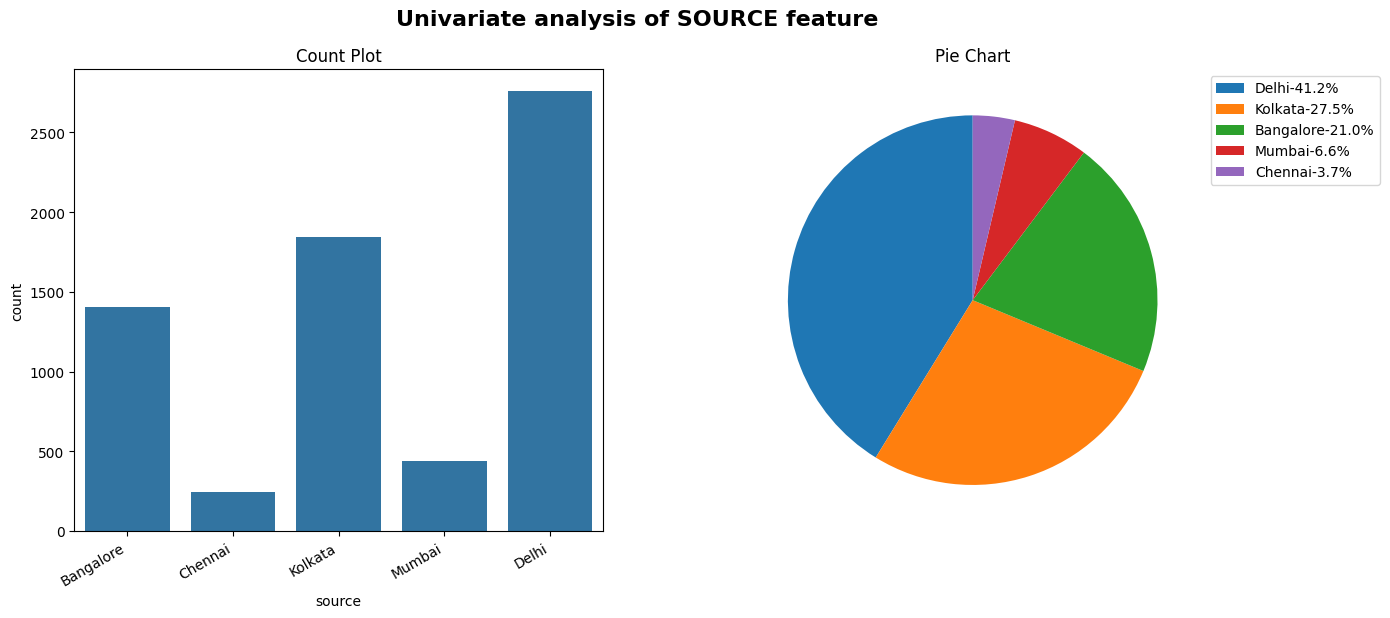

In [ ]:
eda.cat_univar_plots(train,"source")

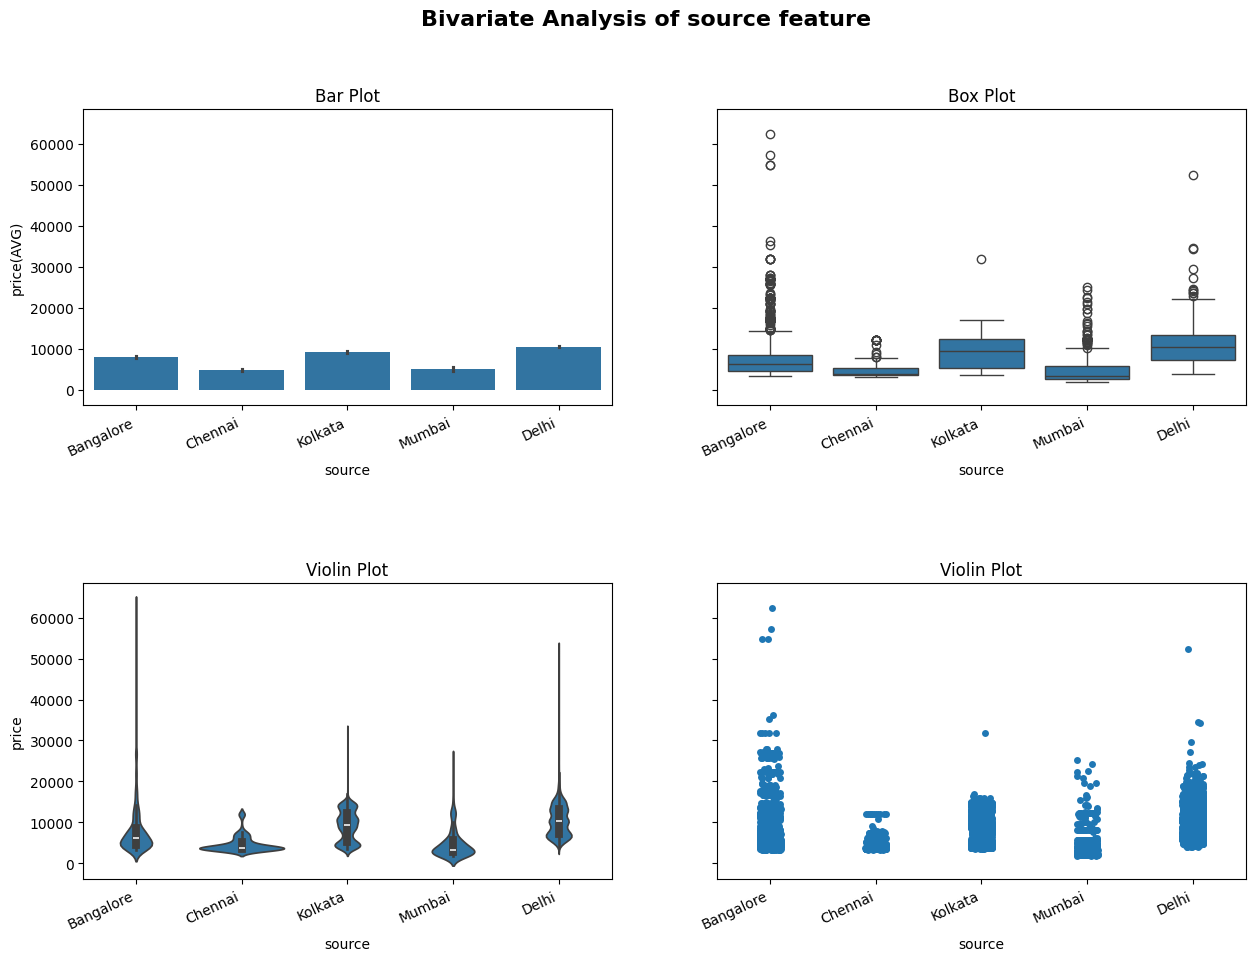

In [ ]:
eda.cat_num_bivar_plots(train,"source","price")

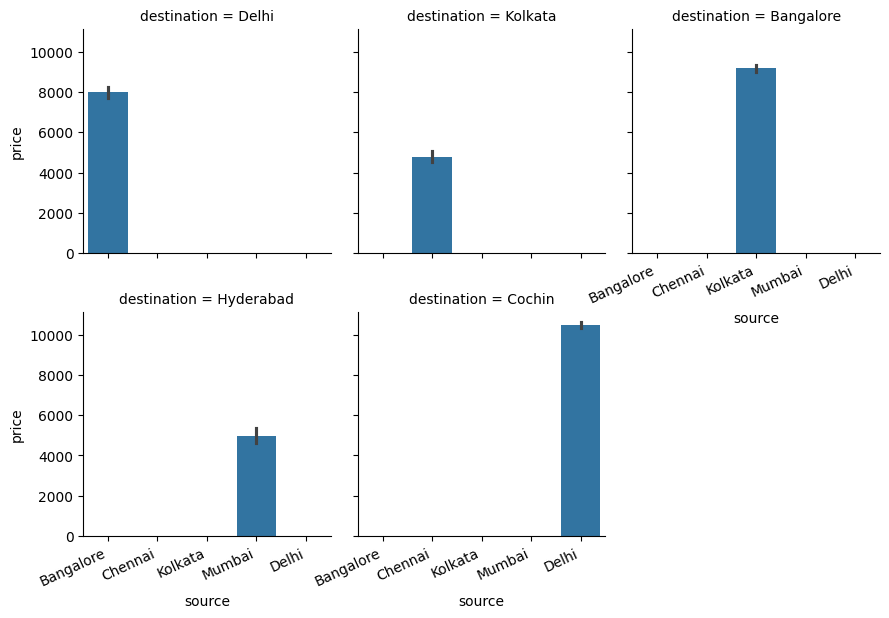

In [ ]:
fg=sns.FacetGrid(train,col="destination",col_wrap=3)
fg.map(sns.barplot,"source","price")
for ax in fg.axes[2:]:
     ax.set_xticklabels(ax.get_xticklabels(),rotation=25,ha="right")
plt.show()

In [ ]:
eda.cat_num_hypothesis_testing(train,"source","price")

╭────────────────────╮
│ ONE WAY ANOVA TEST │
│                    │
╰────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We have enough evidence to reject null hypothesis-> source and price are associated with each other at 5.0% significance level





╭─────────────────────╮
│ Kruskal Wallis TEST │
│                     │
╰─────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We have enough evidence to reject null hypothesis-> source and price are associated with each other at 5.0% significance level


####Observations

**`From Summary`**

  -5 Categories present in `Source` Feature

  -0 missing values

  -`Delhi` represents `41%` of the data

  -followed by Kolkata(27%) and Bangalore(20%)


**`From Univariate Analysis`**

   -`Mumbai` and `Chennai` represents only `10%` of data

   -data wrt `source` is imbalanced


**`From Bivariate Analysis`**

 - price  slightly varies with source

 -distribution of each source wrt price is completely different

 -`Bangalore` has extreme values(outliers)

 -all categories has extreme high values not low values

`
 **`From Hypothesis Testing`**

  -Both tests are saying `source` and `price` are associated with each other

  -our bivariate analysis also given results similair to the test

  **`Final Obseravtion`**

  -From all our observations `source` showing impact on change in `price`

  -`price` can be considered as an important feature

###Destination

In [ ]:
eda.cat_info(train,"destination")

╭──────╮
│ Data │
╰──────╯

9905        Delhi
190         Delhi
7832      Kolkata
1914    Bangalore
9085    Bangalore
          ...    
6021        Delhi
2663    Bangalore
824        Cochin
9158       Cochin
7941    Bangalore
Name: destination, Length: 6695, dtype: object



╭─────────────╮
│ Description │
╰─────────────╯

       destination
count         6695
unique           5
top         Cochin
freq          2759



╭────────────────────────────╮
│ Missing Values Information │
╰────────────────────────────╯

Missing values count: 0 

Missing values Percentage: 0.0 



╭──────────────────────────────────╮
│ Frequency count of each category │
╰──────────────────────────────────╯

             Count  percentages
destination                    
Cochin        2759        41.21
Bangalore     1843        27.53
Delhi         1405        20.99
Hyderabad      442         6.60
Kolkata        246         3.67


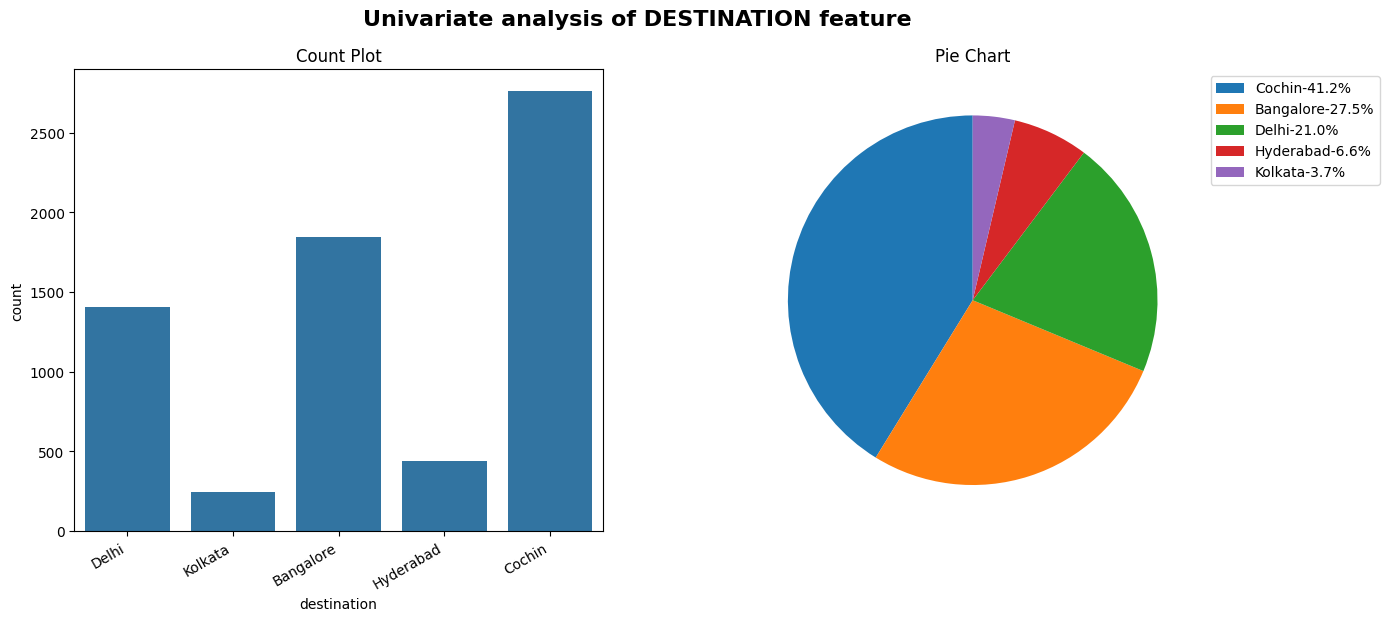

In [ ]:
eda.cat_univar_plots(train,"destination")

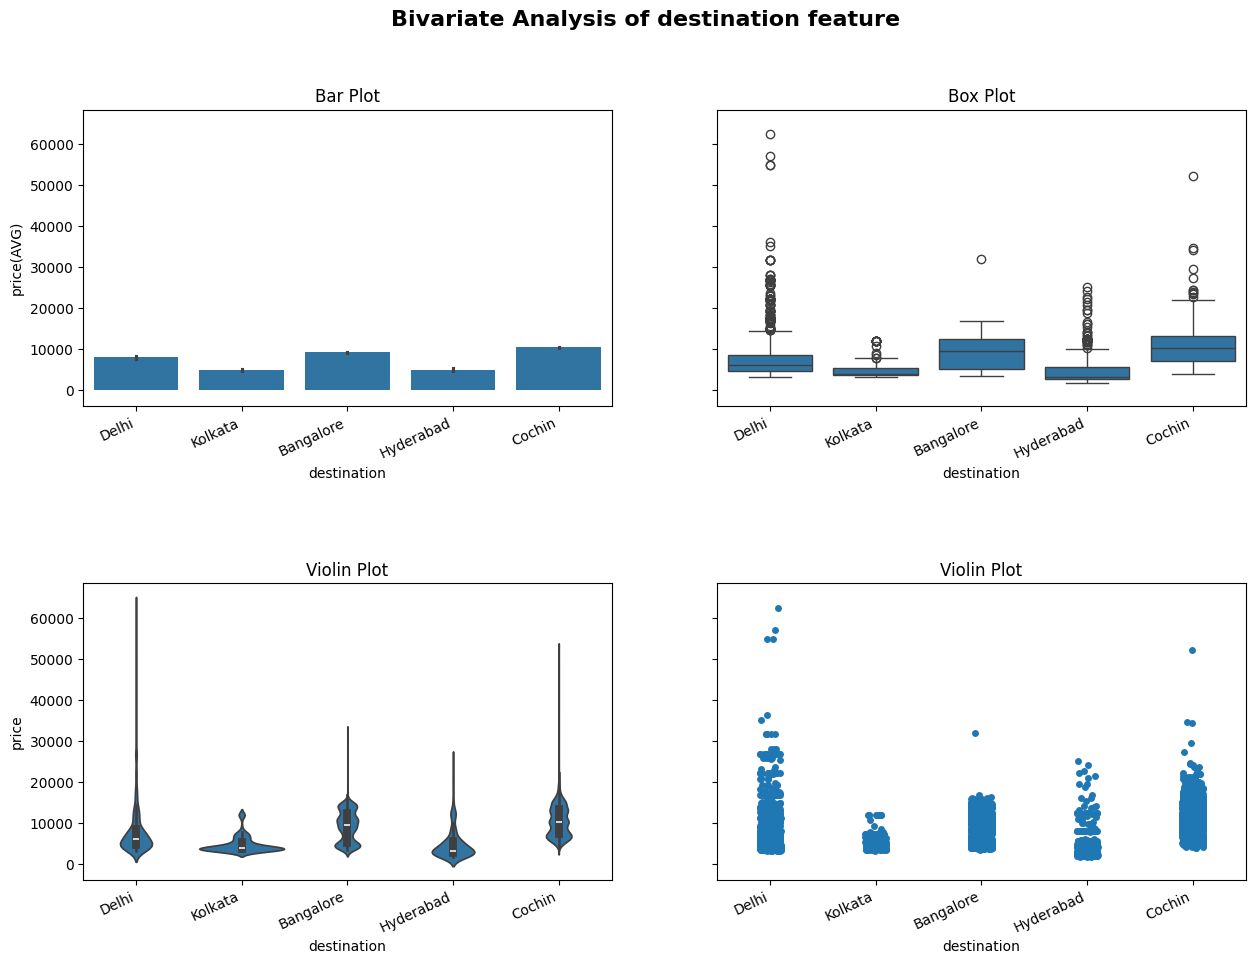

In [ ]:
eda.cat_num_bivar_plots(train,"destination","price")

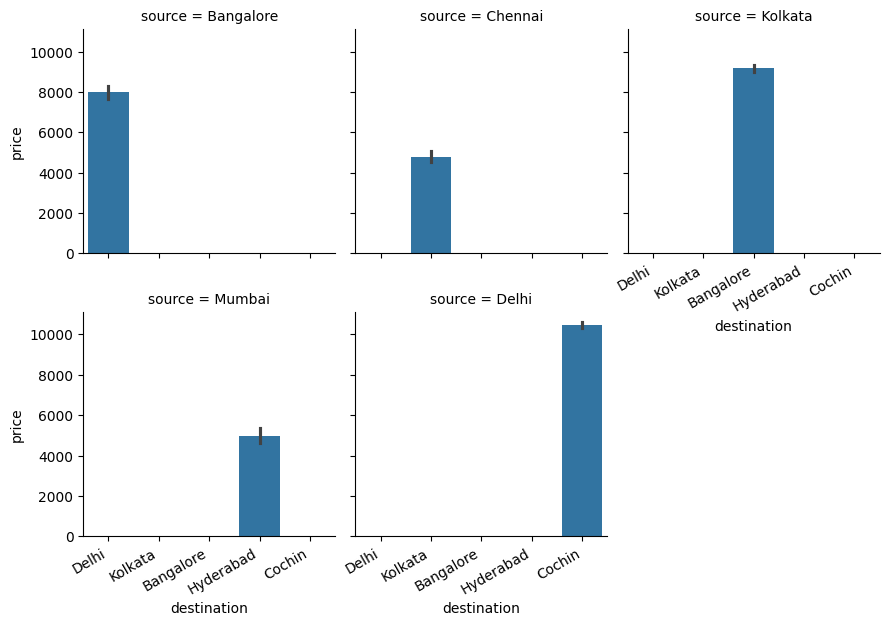

In [ ]:
fg=sns.FacetGrid(data=train,col='source',col_wrap=3)
fg.map(sns.barplot,"destination","price")
for ax in fg.axes[2:]:
     ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha="right")
plt.show()

In [ ]:
eda.cat_num_hypothesis_testing(train,"destination","price")

╭────────────────────╮
│ ONE WAY ANOVA TEST │
│                    │
╰────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We have enough evidence to reject null hypothesis-> destination and price are associated with each other at 5.0% significance level





╭─────────────────────╮
│ Kruskal Wallis TEST │
│                     │
╰─────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We have enough evidence to reject null hypothesis-> destination and price are associated with each other at 5.0% significance level


####Observations

**From Summary**

 -5 categories present in the `destination` feature

 -0 missing values

 -`cochin` represents 41% of the data

 -`Hyderabad` and `Kolkata` represents less than 7% of the data individually


 **From Univariate Analysis**

 -data is imbalanced wrt to `destination` feature

 **From Bivariate Analysis**

 -price slightly varies wrt `destination`

 -distribution of destinations are different

 -`Delhi` and `Cochin` has extreme high values

 **From Hypothesis Testing**

 -Both tests are saying `destination` and `price` are associated with each other

 -our bivariate analysis also given results similair to the test

**Final Obseravtion**

  -From all our observations `destination` showing impact on change in price
  
  - `destination` can be considered as an important feature

###total_stops

In [ ]:
eda.cat_info(train,"total_stops")

╭──────╮
│ Data │
╰──────╯

9905    0
190     1
7832    0
1914    1
9085    0
       ..
6021    0
2663    0
824     0
9158    2
7941    1
Name: total_stops, Length: 6695, dtype: object



╭─────────────╮
│ Description │
╰─────────────╯

       total_stops
count         6695
unique           5
top              1
freq          3586



╭────────────────────────────╮
│ Missing Values Information │
╰────────────────────────────╯

Missing values count: 0 

Missing values Percentage: 0.0 



╭──────────────────────────────────╮
│ Frequency count of each category │
╰──────────────────────────────────╯

             Count  percentages
total_stops                    
1             3586        53.56
0             2228        33.28
2              849        12.68
3               31         0.46
4                1         0.01


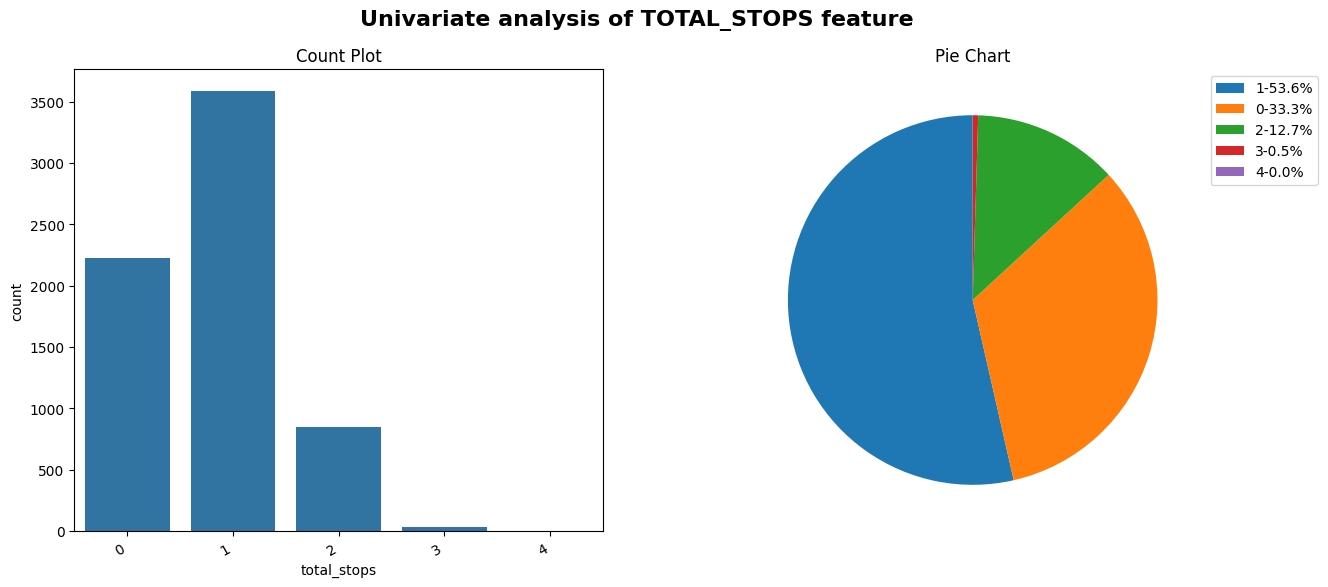

In [ ]:
eda.cat_univar_plots(train,"total_stops")

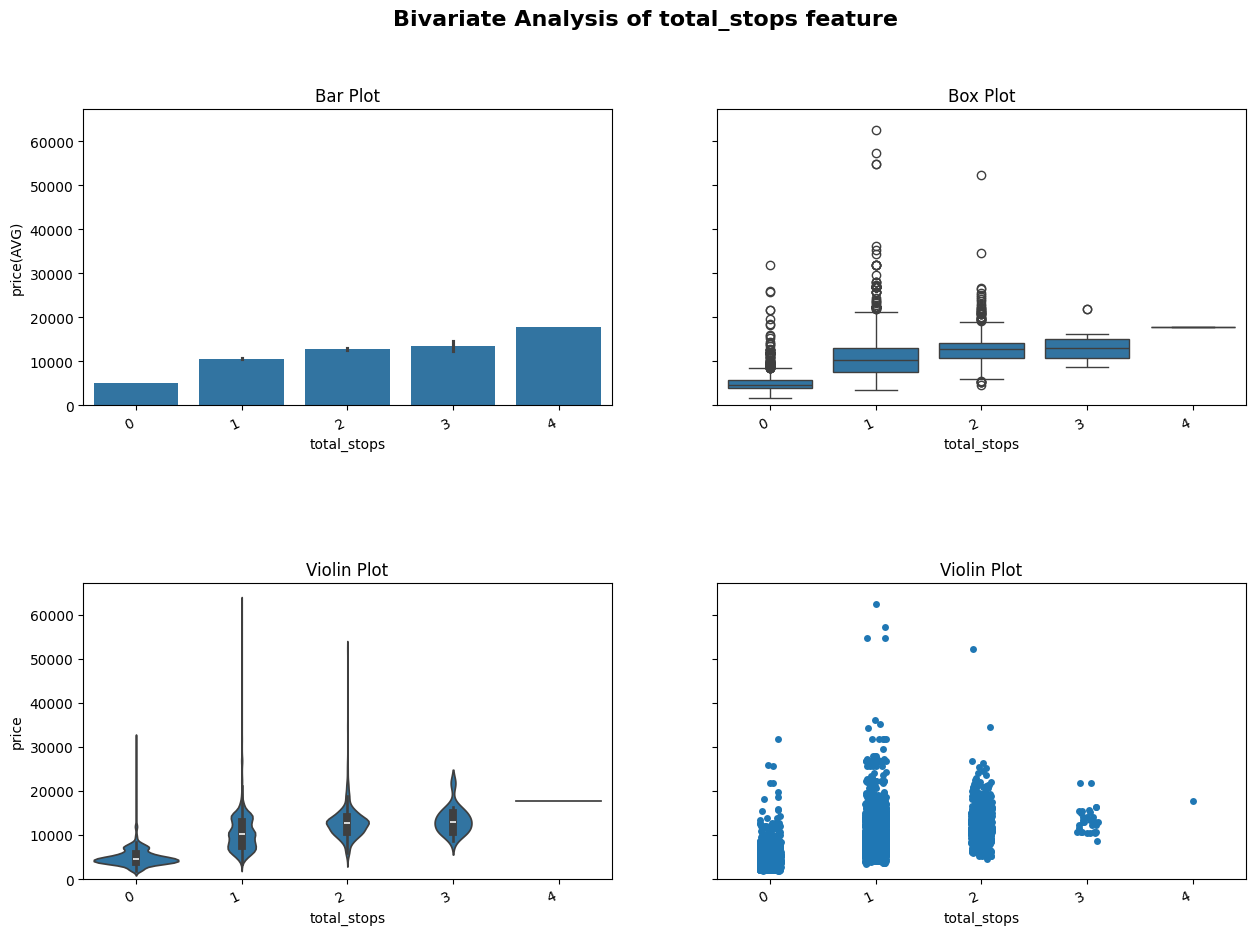

In [ ]:
eda.cat_num_bivar_plots(train,"total_stops","price")

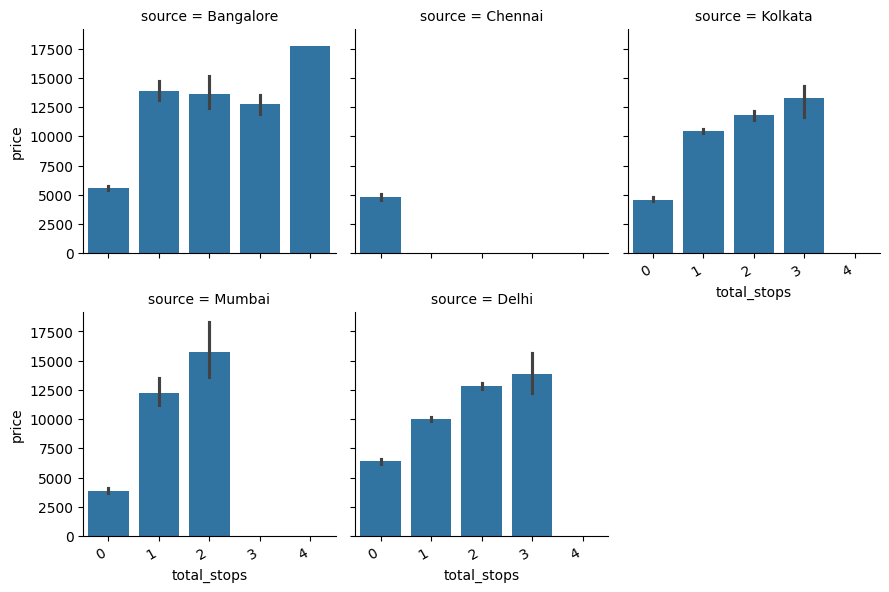

In [ ]:
fg=sns.FacetGrid(data=train,col='source',col_wrap=3)
fg.map(sns.barplot,"total_stops","price")
for ax in fg.axes[2:]:
     ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha="right")
plt.show()

In [ ]:
eda.cat_num_hypothesis_testing(train,"total_stops","price")

╭────────────────────╮
│ ONE WAY ANOVA TEST │
│                    │
╰────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We have enough evidence to reject null hypothesis-> total_stops and price are associated with each other at 5.0% significance level





╭─────────────────────╮
│ Kruskal Wallis TEST │
│                     │
╰─────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We have enough evidence to reject null hypothesis-> total_stops and price are associated with each other at 5.0% significance level


####Observations

**From Summary**

 -5 Categories in total_stops feature

 -o missing values

 - category `1` reprsents `53%` of the samples

 -followed by category `0` represents `33%` of the samples


 **From Univariate Analysis**

 - category `3` and `4` represents less than `0.5%` of the samples


 **From Bivariate Analysis**

 - Price maintaining a linear relationship(positive correlation) with total_stops,where price increasing with increase in total_stops

 -distribution of total stops wrt price is completely different

 -category `1` has extreme high values(outliers)

 -as category `3` and `4` has less samples but they have a significant impact individually


 **From Hypothesis Testing**

 -Both tests are saying `total_stops` and `price` are associated with each other

 -our bivariate analysis also given results similair to the hypothesis test

**Final Obseravtion**

  -From all our observations `total_stops` showing impact on change in price
  
  - `total_stops` can be considered as an important feature

###additional_info

In [ ]:
eda.cat_info(train,"additional_info")

╭──────╮
│ Data │
╰──────╯

9905    No check-in baggage included
190                          No Info
7832                         No Info
1914                         No Info
9085    No check-in baggage included
                    ...             
6021                         No Info
2663                         No Info
824                          No Info
9158                         No Info
7941                         No Info
Name: additional_info, Length: 6695, dtype: object



╭─────────────╮
│ Description │
╰─────────────╯

       additional_info
count             6695
unique               9
top            No Info
freq              5242



╭────────────────────────────╮
│ Missing Values Information │
╰────────────────────────────╯

Missing values count: 0 

Missing values Percentage: 0.0 



╭──────────────────────────────────╮
│ Frequency count of each category │
╰──────────────────────────────────╯

                              Count  percentages
additional_info                                 
No Info                        5242        78.30
In-flight meal not included    1230        18.37
No check-in baggage included    203         3.03
1 Long layover                   12         0.18
Change airports                   3         0.04
Business class                    2         0.03
1 Short layover                   1         0.01
Red-eye flight                    1         0.01
2 Long layover                    1         0.01


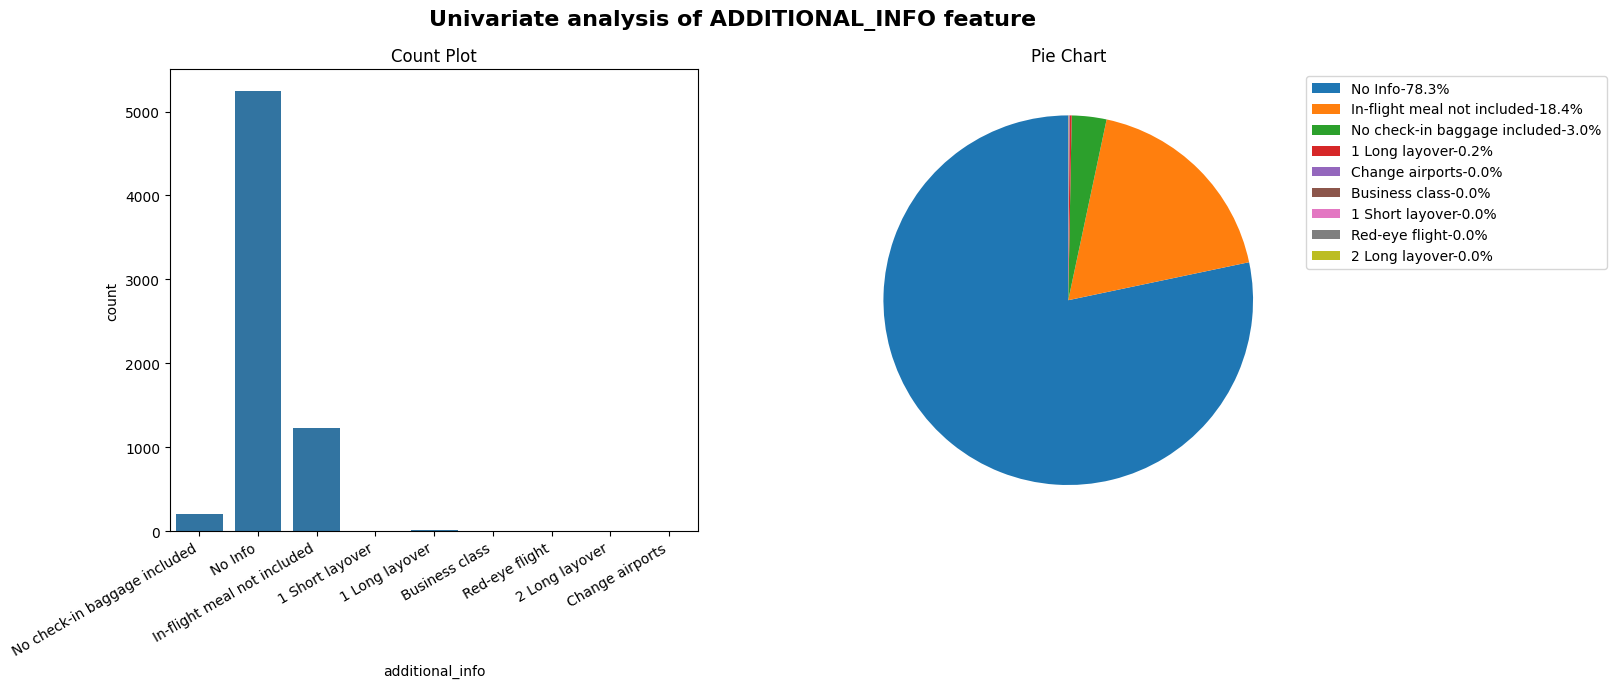

In [ ]:
eda.cat_univar_plots(train,"additional_info")

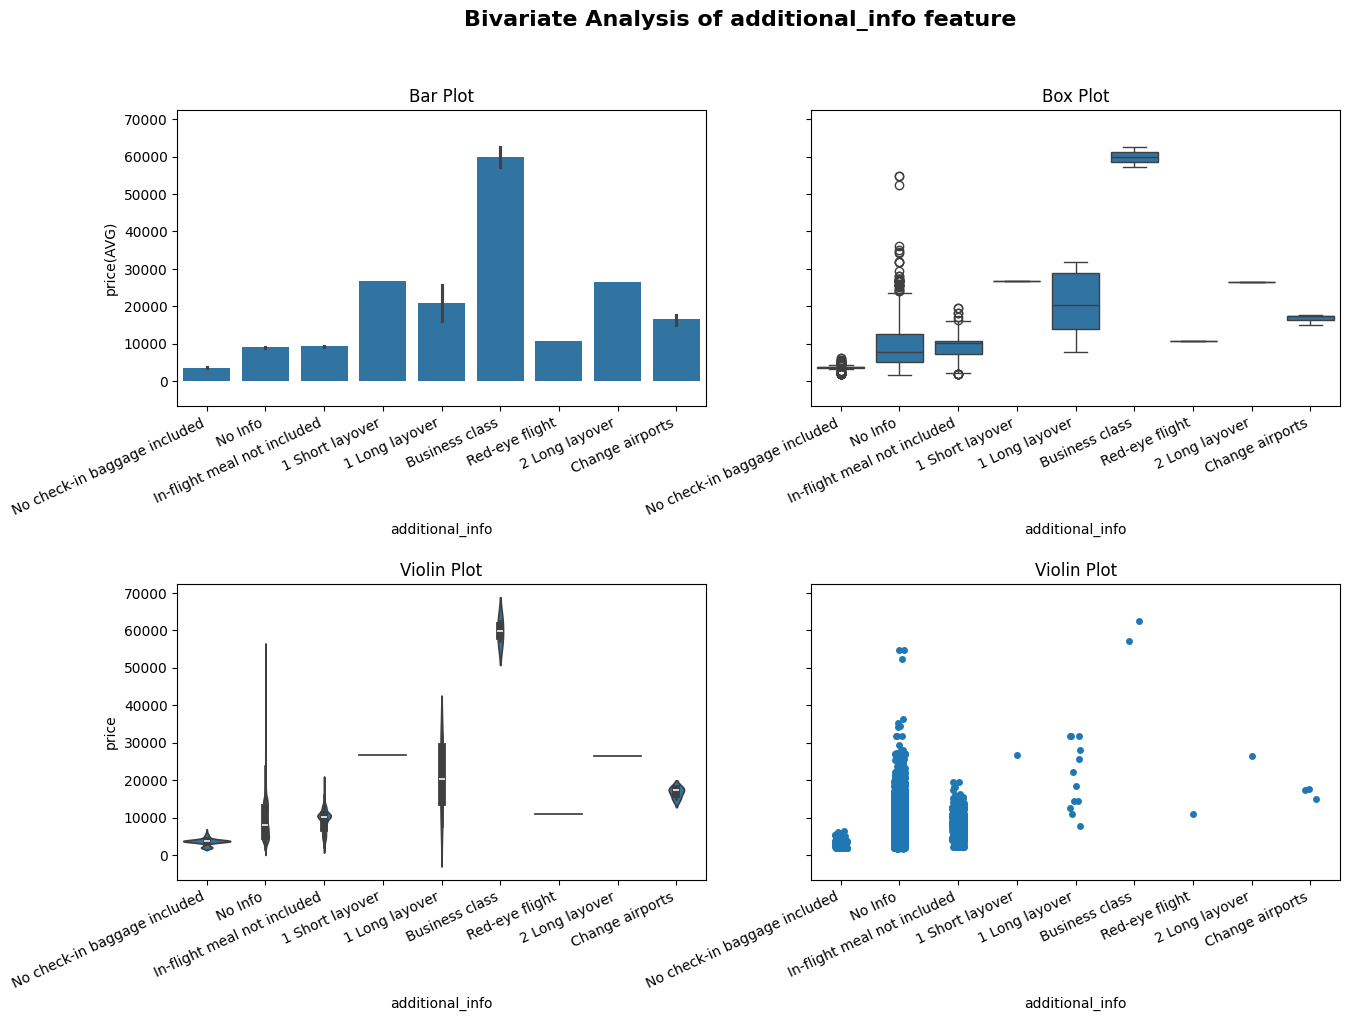

In [ ]:
eda.cat_num_bivar_plots(train,"additional_info","price")

In [ ]:
eda.cat_num_hypothesis_testing(train,"additional_info","price")

╭────────────────────╮
│ ONE WAY ANOVA TEST │
│                    │
╰────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We have enough evidence to reject null hypothesis-> additional_info and price are associated with each other at 5.0% significance level





╭─────────────────────╮
│ Kruskal Wallis TEST │
│                     │
╰─────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We have enough evidence to reject null hypothesis-> additional_info and price are associated with each other at 5.0% significance level


####Observations
  
**From Summary**

-9 categories in additional_info feature

-0 missing values

-`No_info` represents 78% of samples

-7 categories contains less than 3% of samples individually

**From Bivariate Analysis**

-price slighlty varies wrt `additional_info`

-distributions of `additional_info` categories is completely different

**From Hypothesis Testing**

 -Both tests are saying `additional_info` and `price` are associated with each other

 -our bivariate analysis also given results similair to the test

**Final Obseravtion**

  -From all our observations `additional_info` showing impact on change in price
  
  - `additional_info` can be considered as an important feature





###date_of_journey

In [ ]:
(train
.date_of_journey
)

,date_of_journey
9905,2019-06-21
190,2019-03-03
7832,2019-06-09
1914,2019-05-21
9085,2019-04-06
...,...
6021,2019-06-01
2663,2019-04-21
824,2019-03-03
9158,2019-06-03


Text(0, 0.5, 'Average Price')

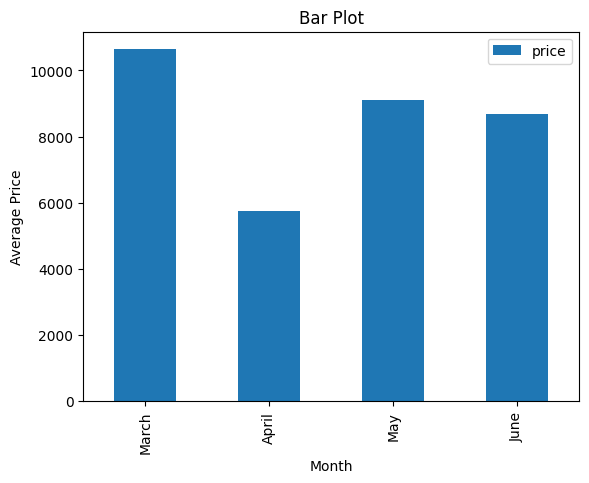

In [ ]:
(train
.groupby(pd.Grouper(key="date_of_journey",freq="M"))
.price.mean()
.to_frame()
.set_axis(["March","April","May","June"],axis=0)
.plot(kind="bar")
)

ax=plt.gca()
ax.set_title("Bar Plot")
ax.set_xlabel("Month")
ax.set_ylabel("Average Price")

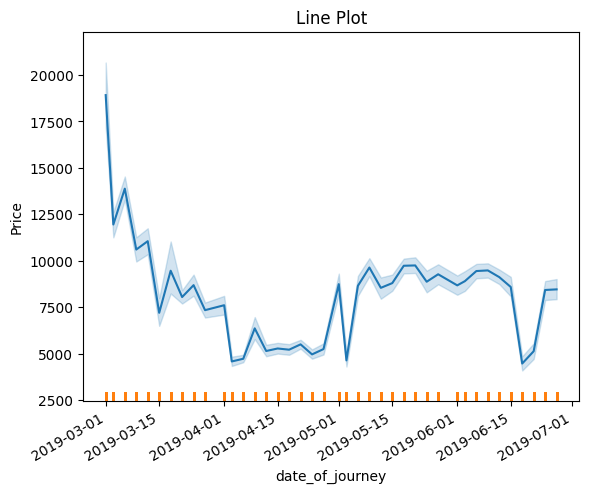

In [ ]:
sns.lineplot(data=train,x="date_of_journey",y='price')
sns.rugplot(data=train,x="date_of_journey")
ax=plt.gca()
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha="right")
ax.set_title("Line Plot")
ax.set_xlabel("date_of_journey")
ax.set_ylabel("Price")
plt.show()

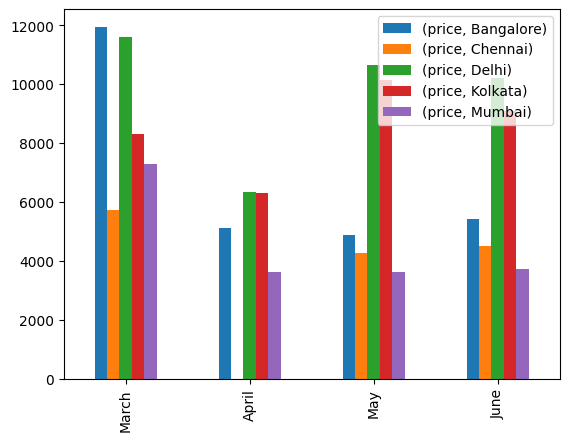

In [ ]:
(train
 .groupby([pd.Grouper(key="date_of_journey",freq="M"),"source"])
 .price
 .mean()
 .to_frame()
 .unstack()
 .set_axis(["March","April","May","June"],axis=0)
 .fillna(value=0)
 .plot(kind="bar")
)

ax=plt.gca()
ax.legend(loc="upper right",bbox_to_anchor=(1,1))


####Observations

 -`price` varies between months(from Bar Plot)

 -`price` varies between the dates(from Line Plot)

 -`price` is associated with the `date_of_journey`

 -`date_of_journey` can consider as an important feature

###duration

In [ ]:
eda.num_info(train,"duration")

╭──────╮
│ Data │
╰──────╯

9905     175
190      295
7832     140
1914     685
9085     155
        ... 
6021     170
2663     155
824      185
9158    1090
7941    1010
Name: duration, Length: 6695, dtype: int32



╭─────────────╮
│ Description │
╰─────────────╯

          duration
count  6695.000000
mean    628.411501
std     503.113488
min      75.000000
25%     170.000000
50%     500.000000
75%     910.000000
max    2860.000000



╭────────────────────────────╮
│ Missing Values Information │
╰────────────────────────────╯

Missing values count: 0 

Missing values Percentage: 0.0 



Skewness: 0.9423486370580355


Kurtosis: 0.0743156565832388


<Axes: xlabel='duration', ylabel='Count'>

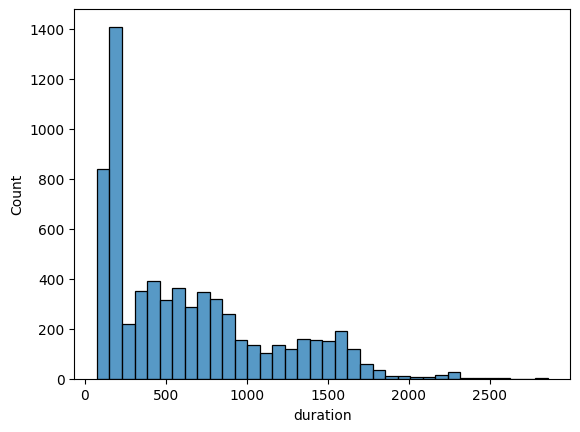

In [ ]:
sns.histplot(data=train,x="duration")

<Axes: xlabel='duration', ylabel='Density'>

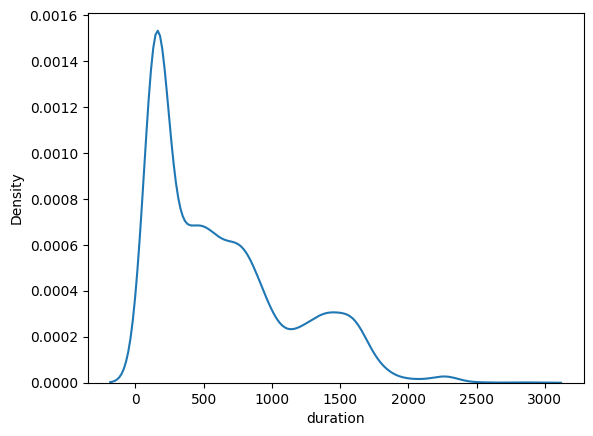

In [ ]:
sns.kdeplot(data=train,x="duration")

<Axes: xlabel='duration'>

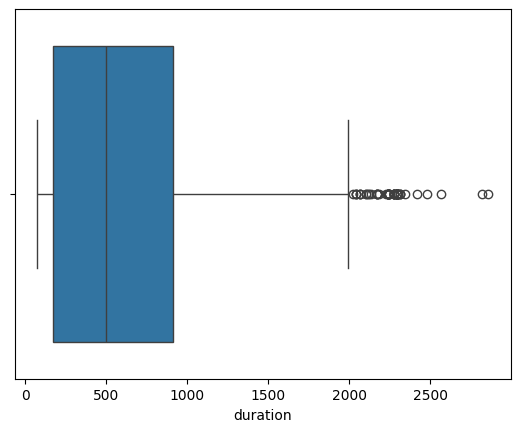

In [ ]:
sns.boxplot(data=train,x="duration")

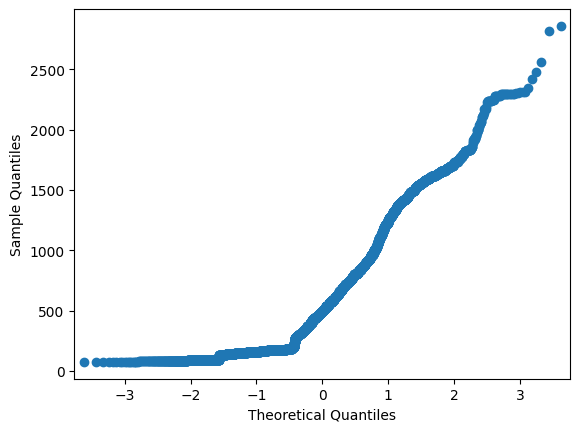

In [ ]:
import statsmodels.api as sm
sm.qqplot(train.duration)
plt.show()

<Axes: xlabel='duration', ylabel='price'>

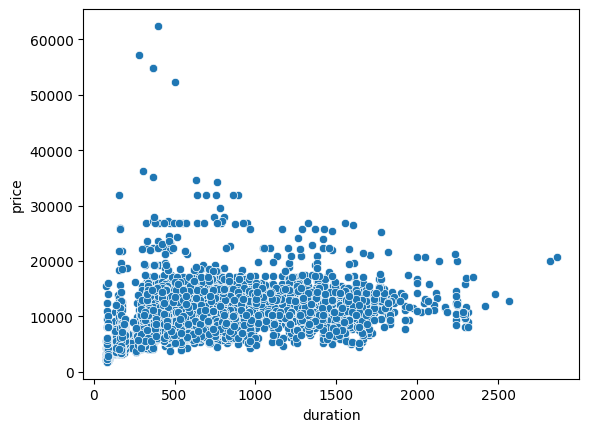

In [ ]:
sns.scatterplot(data=train,x="duration",y="price")

In [ ]:
eda.num_normality_test(train,"duration")

╭───────────────────╮
│ Shapiro-Wilk Test │
╰───────────────────╯

Null Hypothesis: Data is normally distributed

Alternative Hypothesis: Data is not normally distributed

Result: We have enough evidence to reject null hypothesis-> Data does not appears to be normally distributed at 5.0% significance level





╭───────────────────────╮
│ Anderson-Darling Test │
╰───────────────────────╯

Null Hypothesis: Data fits the specified distribution

Alternative Hypothesis: Data does not fits specified distribution

Result:We have enough evidence to reject null hypothesis-> Data does not appears to be normally distributed at 15.0% significance level
Result:We have enough evidence to reject null hypothesis-> Data does not appears to be normally distributed at 10.0% significance level
Result:We have enough evidence to reject null hypothesis-> Data does not appears to be normally distributed at 5.0% significance level
Result:We have enough evidence to reject null hypothesis-> Data does not appears to be normally distributed at 2.5% significance level
Result:We have enough evidence to reject null hypothesis-> Data does not appears to be normally distributed at 1.0% significance level


In [ ]:
eda.num_num_hypothesis_testing(train,"duration","price")

╭───────────────────────╮
│ Pearson’s Correlation │
╰───────────────────────╯

Null Hypothesis: No linear Correlation between variables

Alternative Hypothesis: Linear Correlation between variables

Result: We have enough evidence to reject null hypothesis-> Linear Correlation between variables duration and price at 5.0% significance level





╭─────────────────────────────╮
│ Spearman’s Rank Correlation │
╰─────────────────────────────╯

Null Hypothesis: No Monotonic Correlation between variables

Alternative Hypothesis: Monotonic Correlation between variables

Result: We have enough evidence to reject null hypothesis-> Monotonic Correlation between variables duration and price at 5.0% significance level


In [ ]:
q1=train.duration.quantile([0.25]).values[0]
q3=train.duration.quantile([0.75]).values[0]
iqr=q3-q1
train.query(f"duration>({q3}+(1.5*{iqr}))")



,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
9673,Air India,2019-05-21,Delhi,Cochin,2024-12-03 05:00:00,2024-05-22 19:15:00,2295,2,No Info,9968
7001,Air India,2019-03-24,Kolkata,Bangalore,2024-12-03 12:00:00,2024-03-25 23:15:00,2115,3,No Info,14221
7906,Air India,2019-03-24,Kolkata,Bangalore,2024-12-03 05:55:00,2024-03-25 23:15:00,2480,2,No Info,13990
8698,Air India,2019-03-03,Delhi,Cochin,2024-12-03 07:05:00,2024-03-04 19:15:00,2170,2,No Info,11552
4655,Air India,2019-06-27,Delhi,Cochin,2024-12-03 05:15:00,2024-06-28 19:15:00,2280,3,No Info,10703
7306,Air India,2019-03-03,Delhi,Cochin,2024-12-03 05:00:00,2024-03-04 19:15:00,2295,2,No Info,10283
2654,Jet Airways,2019-03-06,Delhi,Cochin,2024-12-03 05:30:00,2024-03-07 19:45:00,2295,2,In-flight meal not included,15864
7612,Air India,2019-03-18,Bangalore,Delhi,2024-12-03 08:50:00,2024-03-16 23:25:00,2315,2,No Info,10783
7876,Air India,2019-06-06,Delhi,Cochin,2024-12-03 05:15:00,2024-06-07 19:15:00,2280,3,No Info,10703
5933,Air India,2019-05-09,Delhi,Cochin,2024-12-03 05:00:00,2024-05-10 19:15:00,2295,2,No Info,10441


####Observations

**`From Summary`**

-In `Duration` Feature data is not centered around the mean

-high spread 503 where data mainly lies between 128 and 1128

-0 missing values

-high positive skewness(data is right skewed- it has extreme high values)

-small kurtosis(little bit similair to normal distribution,thin tails-less no of extreme values)


**`From Univariate Analysis`**

-Data is Right skewed-More low duration samples,less High duration
samples

-around 500 density of samples is high later density decreasing

-`50%` of the data has duration of 200 to 900 minutes

-Data has extreme high values(outliers)

-from qqpplot we can say data is not normally distributed

**`From Bivariate Analysis`**

-price is slightly assciated with duration

**`From Normality Testing`**

-Data does not appears to be normally distributed

**`From Hypothesis Testing`**

-Linear Correlation between variables duration and price

-price and duration are associated with each other

-duration is an important feature





###dep_time

In [ ]:
 temp_df=(
    train
    .assign(dep_time=lambda df_:pd.Series(np.select([df_.dep_time.dt.hour.between(0,11,inclusive="left"),
                                df_.dep_time.dt.hour.between(11,15,inclusive="left"),
                               df_.dep_time.dt.hour.between(15,18,inclusive="left")],["Morning","Afternoon","Evening"],default="Night"))))






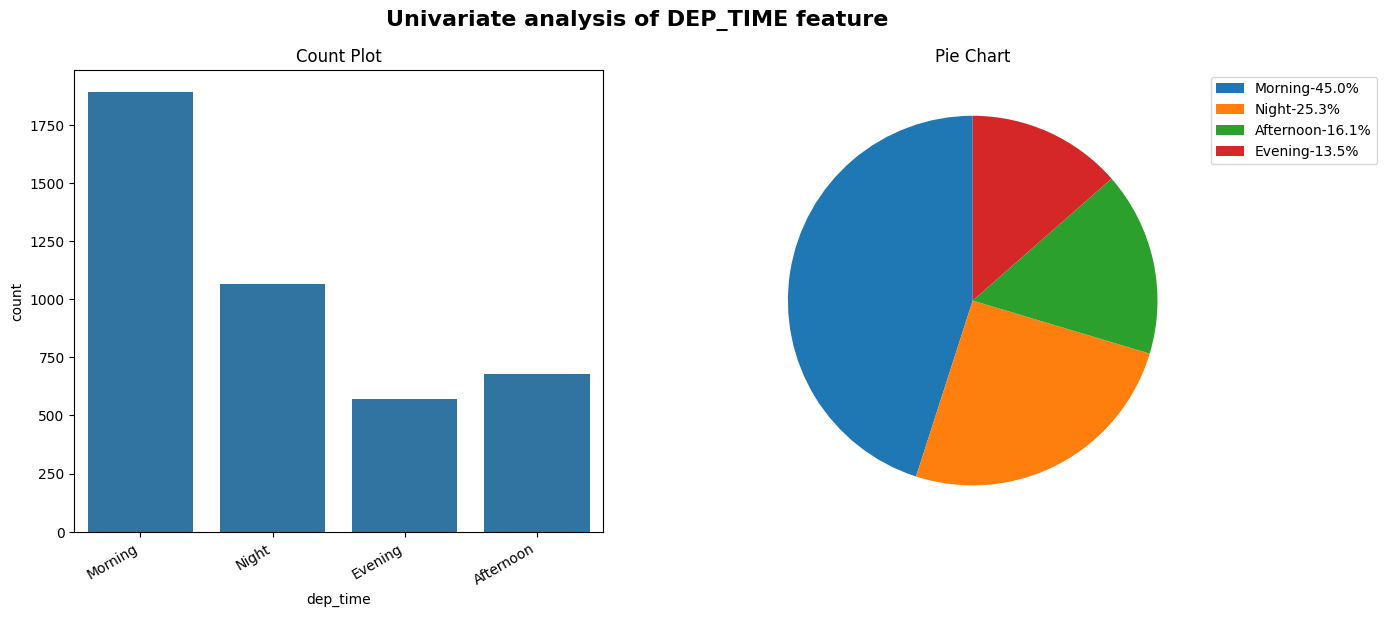

In [ ]:
temp_df.pipe(eda.cat_univar_plots,"dep_time")

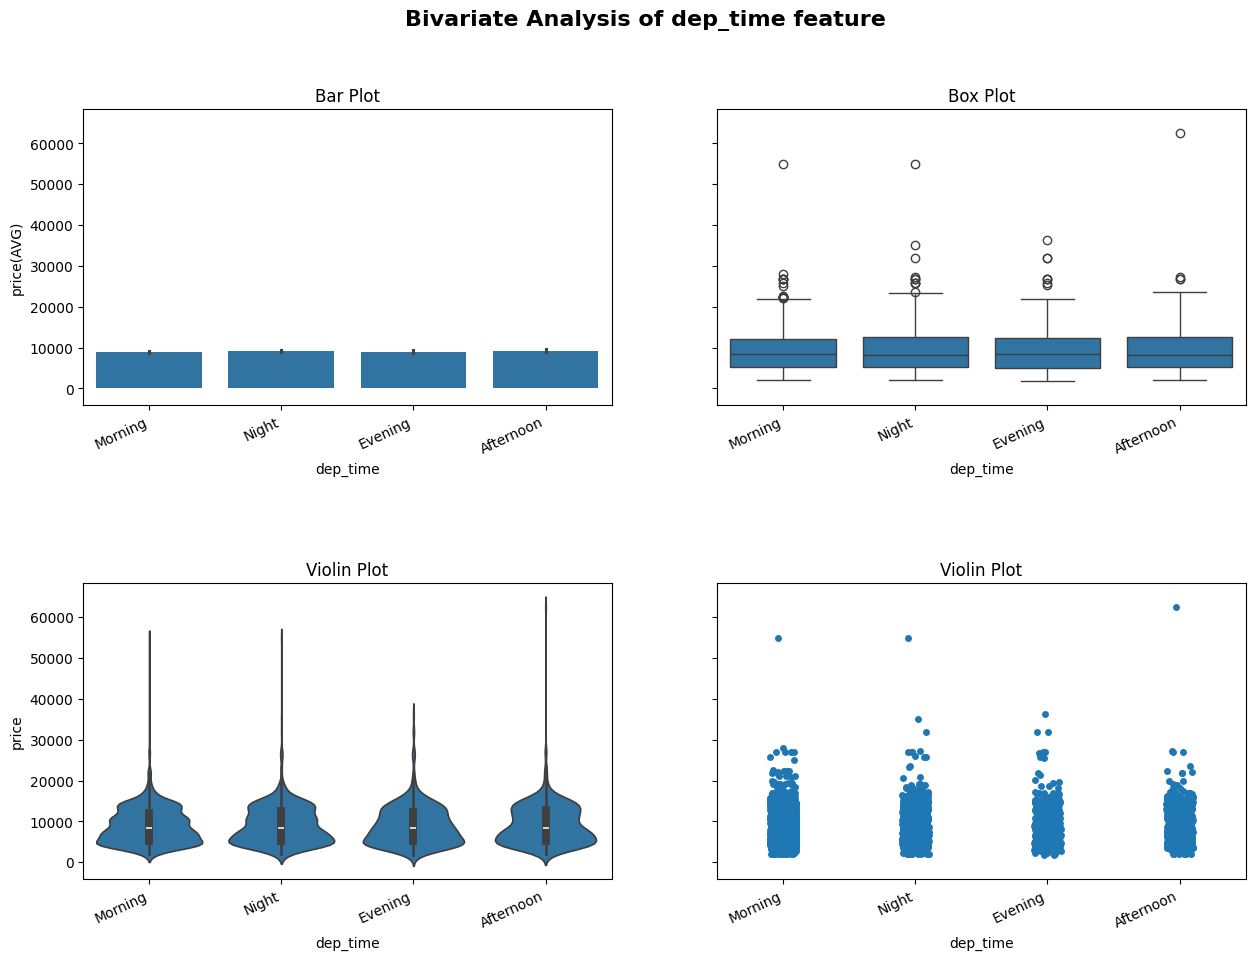

In [ ]:
temp_df.pipe(eda.cat_num_bivar_plots,"dep_time","price")

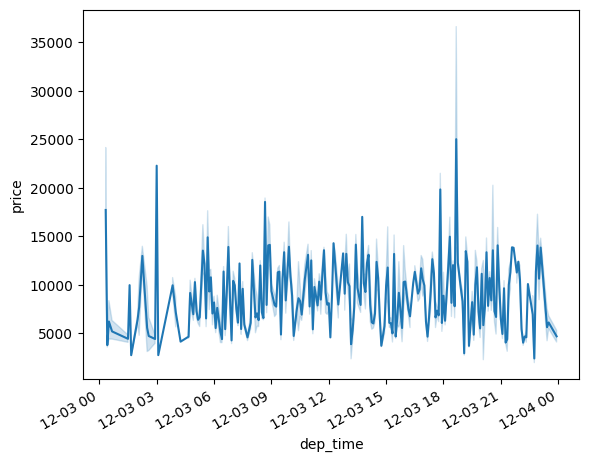

In [ ]:
sns.lineplot(data=train,x="dep_time",y="price")
ax=plt.gca()
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha="right")
plt.show()

In [ ]:
temp_df.pipe(eda.cat_num_hypothesis_testing,"dep_time","price")

╭────────────────────╮
│ ONE WAY ANOVA TEST │
│                    │
╰────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We Failed(not have enough evidence) to reject null hypothesis-> dep_time and price are not associated with each other at 5.0% significance level





╭─────────────────────╮
│ Kruskal Wallis TEST │
│                     │
╰─────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We Failed(not have enough evidence) to reject null hypothesis-> dep_time and price are not associated with each other at 5.0% significance level


####Observations

**`From Univariate Analysis`**

-Most of the flights are depatured at morning(12Am-11Am)(45% of samples)

**`From Bivariate Analysis`**

-Price does not varies much with dep_time(approx price same at each dep_time)

-distributions of dep_time wrt price are almost same

**`From Hypothesis Testing`**

-dep_time and price are not associated with each other

-dep_time may not be an important feature to predict price


###arrival_time

In [ ]:
temp_df=(
    train
    .assign(arrival_time=lambda df_:pd.Series(np.select([df_.arrival_time.dt.hour.between(0,11,inclusive="left"),
                                df_.arrival_time.dt.hour.between(11,15,inclusive="left"),
                                df_.arrival_time.dt.hour.between(15,18,inclusive="left")],["Morning","Afternoon","Evening"],default="Night"))))

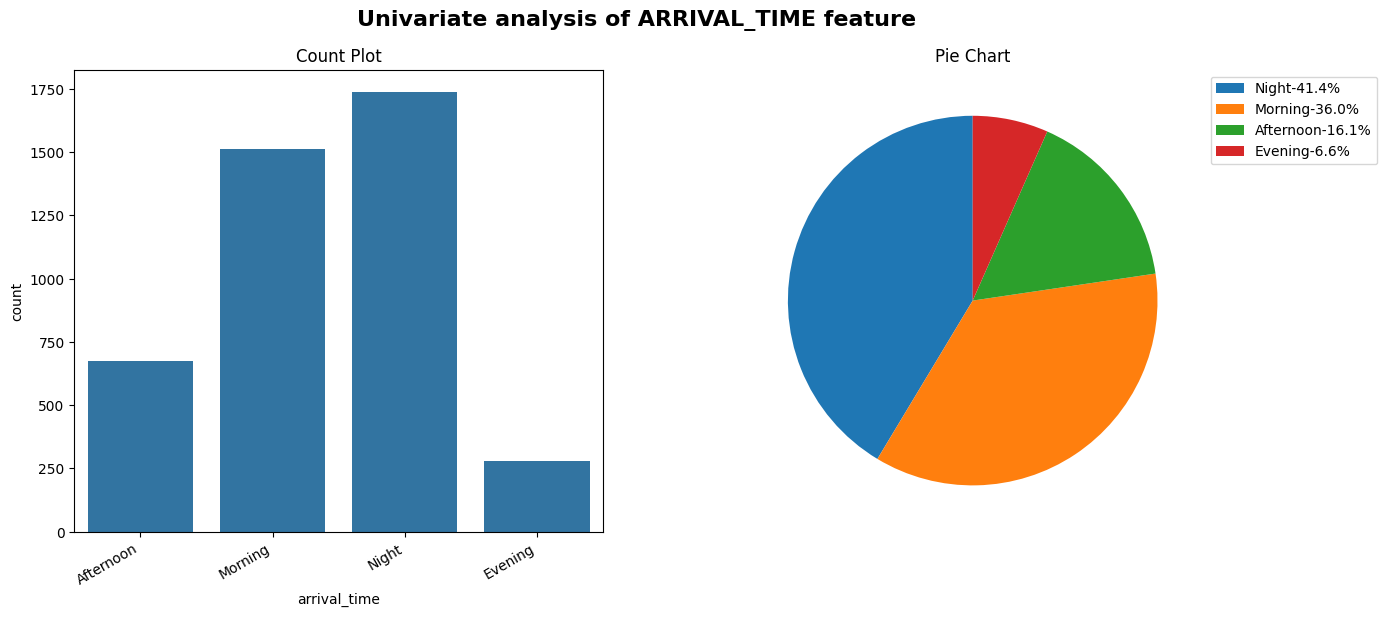

In [ ]:
temp_df.pipe(eda.cat_univar_plots,"arrival_time")

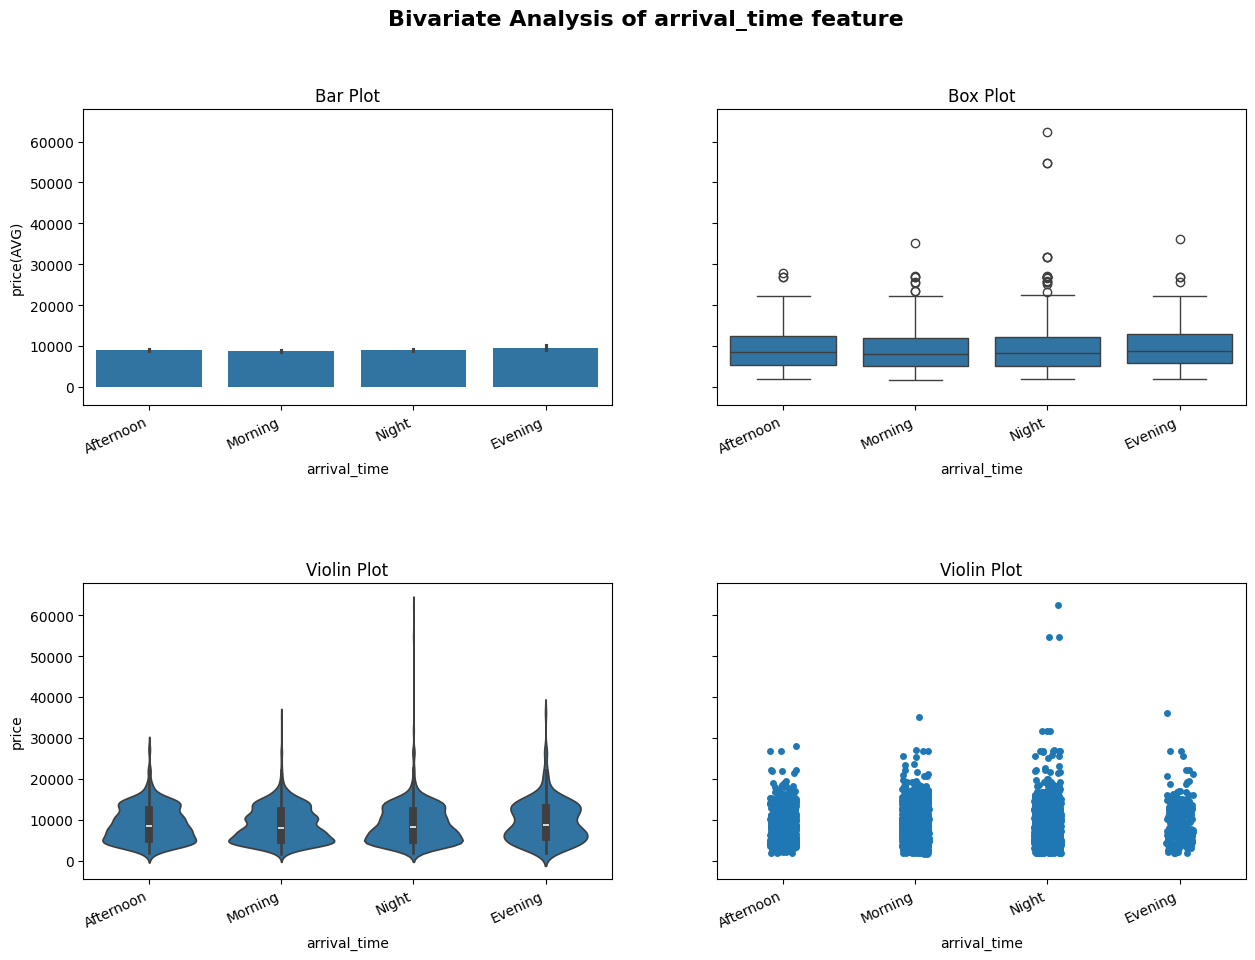

In [ ]:
temp_df.pipe(eda.cat_num_bivar_plots,"arrival_time","price")

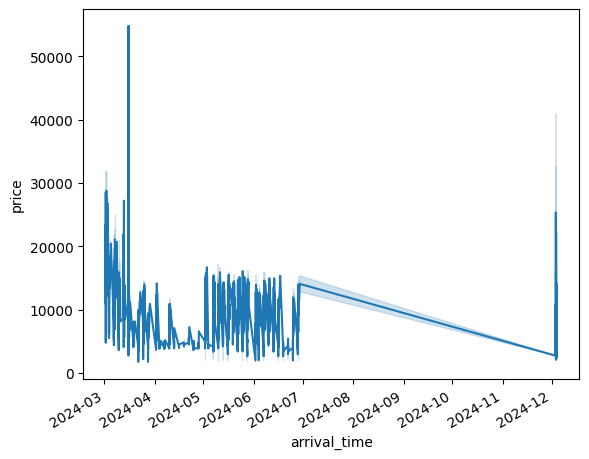

In [ ]:
sns.lineplot(data=train,x="arrival_time",y="price")
ax=plt.gca()
ax.set_xticklabels(ax.get_xticklabels(),rotation=30,ha="right")
plt.show()

In [ ]:
temp_df.pipe(eda.cat_num_hypothesis_testing,"arrival_time","price")

╭────────────────────╮
│ ONE WAY ANOVA TEST │
│                    │
╰────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We Failed(not have enough evidence) to reject null hypothesis-> arrival_time and price are not associated with each other at 5.0% significance level





╭─────────────────────╮
│ Kruskal Wallis TEST │
│                     │
╰─────────────────────╯

Null Hypothesis:means of groups are equal

Alternative Hypothesis:means of groups are not equal

Result: We Failed(not have enough evidence) to reject null hypothesis-> arrival_time and price are not associated with each other at 5.0% significance level


####Observations

**`From Univariate Analysis`**

-Most of the flights are arrived at Night(6pm-12Am)(41% of samples)

**`From Bivariate Analysis`**

-Price does not varies much with arrival_time(approx price same at each arrival_time)

-distributions of arrival_time wrt price are almost same

**`From Hypothesis Testing`**

-arrival_time and price are not associated with each other

-arrival_time may not be an important feature to predict price


##Final Observations



**`Airline`**

-`Jet Airways` represents `35%` of the samples ,where `5` categories individually represents `less than 10%` of the samples

-`airline` showing impact on change in `price`,`airline` can be considered as an important feature

**`Source`**

-Source can be considered an important feature for price prediction.

**`Destination`**

-Destination can be considered an important feature for price prediction.

**`Total_Stops`**

-Total stops can be considered an important feature for price prediction.

**`Date_Of_Journey`**

-Date_Of_Journey can be considered an important feature


**`Duration`**

-Duration can be considered an important feature

**`Dep_Time`**

-Due to lack of association, dep_time may not be an important feature for predicting price.


**`Arrival_Time`**

-Due to lack of association, arrival_time may not be an important feature for predicting price.



##Recommendations



**`Airline`**

 -Address the imbalance in categories to ensure the model doesn't overly favor dominant airlines like Jet Airways.

  **`Source`**

-Address the data imbalance, especially for underrepresented categories like Mumbai and Chennai.

**`Destination`**

-Address the data imbalance, especially for underrepresented categories like Hyderabad and Kolkata.


**`Total-Stops`**

-Address the imbalance in the data, particularly for Categories 3 stops  and 4 stops, to ensure their significance is effectively captured.


**`Duration`**

-Duration need transformation due to right skewness

-Outliers in duration should be handled appropriately to prevent distortion in model training.

-Since the data is not normally distributed, consider using non-parametric models or transformations that accommodate skewed data.

-Model the association between duration and price carefully, especially since the relationship is linear but weak.

**`Dep_Time`**

- Better to remove dep_time from the feature set for price prediction, as it doesn’t add much predictive value.

**`Arrival_Time`**

- Better to remove arrival_time from the feature set for price prediction, as it doesn’t add much predictive value.



#Feature Engineering

In [ ]:
train.head()

,airline,date_of_journey,source,destination,dep_time,arrival_time,duration,total_stops,additional_info,price
9905,Spicejet,2019-06-21,Bangalore,Delhi,2024-12-03 21:10:00,2024-06-22 00:05:00,175,0,No check-in baggage included,3919
190,Indigo,2019-03-03,Bangalore,Delhi,2024-12-03 12:10:00,2024-12-03 17:05:00,295,1,No Info,8738
7832,Indigo,2019-06-09,Chennai,Kolkata,2024-12-03 13:15:00,2024-12-03 15:35:00,140,0,No Info,3597
1914,Jet Airways,2019-05-21,Kolkata,Bangalore,2024-12-03 08:25:00,2024-12-03 19:50:00,685,1,No Info,14781
9085,Spicejet,2019-04-06,Kolkata,Bangalore,2024-12-03 06:55:00,2024-12-03 09:30:00,155,0,No check-in baggage included,3841


In [ ]:
train_x=train.drop("price",axis=1)
train_y=train.price.copy()

In [ ]:
train_x.dtypes

,0
airline,object
date_of_journey,datetime64[ns]
source,object
destination,object
dep_time,datetime64[ns]
arrival_time,datetime64[ns]
duration,int32
total_stops,object
additional_info,object


###Airline

In [ ]:
(
    train_x
    .airline
    .value_counts()
)

,count
airline,
Jet Airways,2386
Indigo,1296
Air India,1064
Multiple Carriers,767
Spicejet,513
Vistara,323
Air Asia,220
Goair,125
Trujet,1


In [ ]:
airline_pipe=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("rarelabelencoder",RareLabelEncoder(tol=0.1,n_categories=2,replace_with="Other")),
    ("onehotencoder",OneHotEncoder(sparse_output=False))

]
)

airline_pipe.fit_transform(train_x[["airline"]])#.value_counts()

,airline_Air India,airline_Indigo,airline_Jet Airways,airline_Multiple Carriers,airline_Other
9905,0.0,0.0,0.0,0.0,1.0
190,0.0,1.0,0.0,0.0,0.0
7832,0.0,1.0,0.0,0.0,0.0
1914,0.0,0.0,1.0,0.0,0.0
9085,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...
6021,0.0,1.0,0.0,0.0,0.0
2663,0.0,0.0,0.0,0.0,1.0
824,1.0,0.0,0.0,0.0,0.0
9158,0.0,0.0,1.0,0.0,0.0


###Date_Of_Journey

In [ ]:
train_x.date_of_journey

,date_of_journey
9905,2019-06-21
190,2019-03-03
7832,2019-06-09
1914,2019-05-21
9085,2019-04-06
...,...
6021,2019-06-01
2663,2019-04-21
824,2019-03-03
9158,2019-06-03


In [ ]:
def missing_dt(x):
  return x.fillna(method="ffill")

In [ ]:
extract_features=["month","weekend","day_of_month"]
doj_pipe=Pipeline(steps=[
    ("imputer",FunctionTransformer(func=missing_dt)),
    ("datetime",DatetimeFeatures(features_to_extract=extract_features,yearfirst=True,format="%Y-%m-%d")),
    ("scaler",MinMaxScaler())
])

doj_pipe.fit_transform(train_x[["date_of_journey"]])

,date_of_journey_month,date_of_journey_weekend,date_of_journey_day_of_month
9905,1.000000,0.0,0.769231
190,0.000000,1.0,0.076923
7832,1.000000,1.0,0.307692
1914,0.666667,0.0,0.769231
9085,0.333333,1.0,0.192308
...,...,...,...
6021,1.000000,1.0,0.000000
2663,0.333333,1.0,0.769231
824,0.000000,1.0,0.076923
9158,1.000000,0.0,0.076923


###Source & Destination

In [ ]:
print(train_x.source.value_counts())
print()
print(train_x.destination.value_counts())

source
Delhi        2759
Kolkata      1843
Bangalore    1405
Mumbai        442
Chennai       246
Name: count, dtype: int64

destination
Cochin       2759
Bangalore    1843
Delhi        1405
Hyderabad     442
Kolkata       246
Name: count, dtype: int64


In [ ]:
location_pipe1=Pipeline(steps=[
         ("rarelabelencoder",RareLabelEncoder(tol=0.1,n_categories=2,replace_with="Other")),
         ("onehotencoder",OneHotEncoder(sparse_output=False))
                              ])

location_pipe1.fit_transform(train_x[["source","destination"]])

,source_Bangalore,source_Delhi,source_Kolkata,source_Other,destination_Bangalore,destination_Cochin,destination_Delhi,destination_Other
9905,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
190,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
7832,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1914,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
9085,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
6021,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2663,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
824,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0
9158,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0


In [ ]:
np.union1d(train_x.source.unique().tolist(),train_x.destination.unique().tolist())

array(['Bangalore', 'Chennai', 'Cochin', 'Delhi', 'Hyderabad', 'Kolkata',
       'Mumbai'], dtype='<U9')

In [ ]:
def location_feature(x):
  columns=x.columns.tolist()
  north=["Delhi","Kolkata","Mumbai"]

  return (
    x
    .assign(**{
        f"{col}_is_north": x[col].isin(north).astype(int)
        for col in columns}
    )
    .drop(columns=columns)
  )

In [ ]:
location_union=FeatureUnion(transformer_list=[
    ("pipe1",location_pipe1),
    ("pipe2",FunctionTransformer(func=location_feature))

])

location_transformer=Pipeline([
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("union",location_union)
])




location_transformer.fit_transform(train_x[["source","destination"]])

,source_Bangalore,source_Delhi,source_Kolkata,source_Other,destination_Bangalore,destination_Cochin,destination_Delhi,destination_Other,source_is_north,destination_is_north
9905,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
190,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
7832,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1
1914,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0
9085,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0
...,...,...,...,...,...,...,...,...,...,...
6021,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1
2663,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0
824,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0
9158,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0


###Dep_Time & Arrival_Time

In [ ]:
print(train_x.dep_time)
print()
print(train_x.arrival_time)

9905   2024-12-03 21:10:00
190    2024-12-03 12:10:00
7832   2024-12-03 13:15:00
1914   2024-12-03 08:25:00
9085   2024-12-03 06:55:00
               ...        
6021   2024-12-03 13:00:00
2663   2024-12-03 06:55:00
824    2024-12-03 18:05:00
9158   2024-12-03 18:25:00
7941   2024-12-03 16:30:00
Name: dep_time, Length: 6695, dtype: datetime64[ns]

9905   2024-06-22 00:05:00
190    2024-12-03 17:05:00
7832   2024-12-03 15:35:00
1914   2024-12-03 19:50:00
9085   2024-12-03 09:30:00
               ...        
6021   2024-12-03 15:50:00
2663   2024-12-03 09:30:00
824    2024-12-03 21:10:00
9158   2024-06-04 12:35:00
7941   2024-05-13 09:20:00
Name: arrival_time, Length: 6695, dtype: datetime64[ns]


In [ ]:
time_features=["hour","minute"]
time_pipe1=Pipeline(steps=[
    ("datetime",DatetimeFeatures(features_to_extract=time_features,yearfirst=True,format='mixed')),
    ("scaler",MinMaxScaler())
])

time_pipe1.fit_transform(train_x[["dep_time","arrival_time"]])

,dep_time_hour,dep_time_minute,arrival_time_hour,arrival_time_minute
9905,0.913043,0.181818,0.000000,0.090909
190,0.521739,0.181818,0.739130,0.090909
7832,0.565217,0.272727,0.652174,0.636364
1914,0.347826,0.454545,0.826087,0.909091
9085,0.260870,1.000000,0.391304,0.545455
...,...,...,...,...
6021,0.565217,0.000000,0.652174,0.909091
2663,0.260870,1.000000,0.391304,0.545455
824,0.782609,0.090909,0.913043,0.181818
9158,0.782609,0.454545,0.521739,0.636364


In [ ]:
def time_feature(x):
  columns=x.columns.tolist()

  return (
      x
      .assign(**{
          f"{col}_part_of_day":np.select([x[col].dt.hour.between(4,12,inclusive="left"),
          x[col].dt.hour.between(12,16,inclusive="left"),
          x[col].dt.hour.between(16,19,inclusive="left")],["Morning","Afternoon","Evening"],default="Night")
          for col in columns
      })
      .drop(columns=columns)
  )

In [ ]:
time_feature(train_x[["dep_time","arrival_time"]])

,dep_time_part_of_day,arrival_time_part_of_day
9905,Night,Night
190,Afternoon,Evening
7832,Afternoon,Afternoon
1914,Morning,Night
9085,Morning,Morning
...,...,...
6021,Afternoon,Afternoon
2663,Morning,Morning
824,Evening,Night
9158,Evening,Afternoon


In [ ]:
time_pipe2=Pipeline(steps=[
    ("feature",FunctionTransformer(func=time_feature)),
    ("onehotencoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))

])

time_pipe2.fit_transform(train_x[["dep_time","arrival_time"]])

,dep_time_part_of_day_Afternoon,dep_time_part_of_day_Evening,dep_time_part_of_day_Morning,dep_time_part_of_day_Night,arrival_time_part_of_day_Afternoon,arrival_time_part_of_day_Evening,arrival_time_part_of_day_Morning,arrival_time_part_of_day_Night
9905,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
190,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7832,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1914,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
9085,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...
6021,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2663,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
824,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0
9158,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0


In [ ]:
time_union=FeatureUnion(transformer_list=[
     ("pipe1",time_pipe1),
    ("pipe2",time_pipe2)

])

time_transformer=Pipeline(steps=[
    ("imputer",FunctionTransformer(func=missing_dt)),
    ("union",time_union)
])

time_transformer.fit_transform(train_x[["dep_time"]])

,dep_time_hour,dep_time_minute,dep_time_part_of_day_Afternoon,dep_time_part_of_day_Evening,dep_time_part_of_day_Morning,dep_time_part_of_day_Night
9905,0.913043,0.181818,0.0,0.0,0.0,1.0
190,0.521739,0.181818,1.0,0.0,0.0,0.0
7832,0.565217,0.272727,1.0,0.0,0.0,0.0
1914,0.347826,0.454545,0.0,0.0,1.0,0.0
9085,0.260870,1.000000,0.0,0.0,1.0,0.0
...,...,...,...,...,...,...
6021,0.565217,0.000000,1.0,0.0,0.0,0.0
2663,0.260870,1.000000,0.0,0.0,1.0,0.0
824,0.782609,0.090909,0.0,1.0,0.0,0.0
9158,0.782609,0.454545,0.0,1.0,0.0,0.0


###Duration

In [ ]:
train_x.duration

,duration
9905,175
190,295
7832,140
1914,685
9085,155
...,...
6021,170
2663,155
824,185
9158,1090


In [ ]:
train_x.duration.describe()

,duration
count,6695.000000
mean,628.411501
std,503.113488
min,75.000000
25%,170.000000
50%,500.000000
75%,910.000000
max,2860.000000


In [ ]:
def duration_feature1(x):
  columns=x.columns.tolist()
  return (
      x
      .assign(**{
          f"{col}_range":np.select([x[col].between(75,300,inclusive="left"),
            x[col].between(300,800,inclusive="left")],["Short","Medium"],default="Long")
          for col in columns
      }

      )
      .drop(columns=columns)
  )

In [ ]:
duration_feature1(train_x[["duration"]])

,duration_range
9905,Short
190,Short
7832,Short
1914,Medium
9085,Short
...,...
6021,Short
2663,Short
824,Short
9158,Long


In [215]:
duration_pipe1=Pipeline(steps=[
    ("feature1",FunctionTransformer(func=duration_feature1)),
    ("ordinalencoder",OrdinalEncoder())
])

duration_pipe1.fit_transform(train_x[["duration"]])

,duration_range
9905,2.0
190,2.0
7832,2.0
1914,1.0
9085,2.0
...,...
6021,2.0
2663,2.0
824,2.0
9158,0.0


In [ ]:
def duration_feature2(df):
  columns=df.columns.tolist()
  quantiles=[0.25,0.5,0.75]
  reference={
      col:
      (df[col]
       .quantile(quantiles)
       .values.reshape(-1,1))
      for col in columns
  }

  obj=[]
  for var in reference:
    col=[f"{var}_{int(q*100)}th" for q in quantiles]
    data=pd.DataFrame(rbf_kernel(X=df[[var]],Y=reference[var]),columns=col,index=df.index)
    obj.append(data)

  return pd.concat(obj,axis=1)



duration_feature2(train_x[["duration"]])

,duration_25th,duration_50th,duration_75th
9905,1.388794e-11,0.0,0.0
190,0.000000e+00,0.0,0.0
7832,0.000000e+00,0.0,0.0
1914,0.000000e+00,0.0,0.0
9085,1.921948e-98,0.0,0.0
...,...,...,...
6021,1.000000e+00,0.0,0.0
2663,1.921948e-98,0.0,0.0
824,1.921948e-98,0.0,0.0
9158,0.000000e+00,0.0,0.0


In [ ]:
duration_pipe2=Pipeline(steps=[
    ("feature2",FunctionTransformer(duration_feature2)),
    ("powertransformer",PowerTransformer(standardize=True))
])

duration_pipe2.fit_transform(train_x[["duration"]])

,duration_25th,duration_50th,duration_75th
9905,-0.237684,-0.051921,-0.063633
190,-0.237684,-0.051921,-0.063633
7832,-0.237684,-0.051921,-0.063633
1914,-0.237684,-0.051921,-0.063633
9085,-0.237684,-0.051921,-0.063633
...,...,...,...
6021,4.207270,-0.051921,-0.063633
2663,-0.237684,-0.051921,-0.063633
824,-0.237684,-0.051921,-0.063633
9158,-0.237684,-0.051921,-0.063633


In [216]:
duration_union=FeatureUnion(transformer_list=[
    ("pipe1",duration_pipe1),
    ("pipe2",duration_pipe2),
    ("scaler",StandardScaler())
])


duration_transformer=Pipeline(steps=[
    ("outlier",Winsorizer(capping_method="iqr",fold=1.5)),
    ("uniont",duration_union),
    ("imputer",SimpleImputer(strategy="median"))

])

duration_transformer.fit_transform(train_x[["duration"]])

,duration_range,duration_25th,duration_50th,duration_75th,duration
9905,2.0,-0.237684,-0.051921,-0.063633,-0.908932
190,2.0,-0.237684,-0.051921,-0.063633,-0.667256
7832,2.0,-0.237684,-0.051921,-0.063633,-0.979421
1914,1.0,-0.237684,-0.051921,-0.063633,0.118192
9085,2.0,-0.237684,-0.051921,-0.063633,-0.949211
...,...,...,...,...,...
6021,2.0,4.207270,-0.051921,-0.063633,-0.919002
2663,2.0,-0.237684,-0.051921,-0.063633,-0.949211
824,2.0,-0.237684,-0.051921,-0.063633,-0.888792
9158,0.0,-0.237684,-0.051921,-0.063633,0.933850


###Total_Stops

In [ ]:
train_x.total_stops.value_counts()

,count
total_stops,
1,3586
0,2228
2,849
3,31
4,1


In [ ]:
stops_pipe=Pipeline(steps=[
    ("rarelabelencoder",RareLabelEncoder(tol=0.1,replace_with="3",n_categories=2))

])

stops_pipe.fit_transform(train_x[["total_stops"]])

,total_stops
9905,0
190,1
7832,0
1914,1
9085,0
...,...
6021,0
2663,0
824,0
9158,2


In [ ]:
def stops_feature(x):
  columns=x.columns.tolist()

  return(
    x
    .assign(**{
        "is_direct_flight":x[col].isin(["1"]).astype(int)
        for col in columns
        })
    .drop(columns,axis=1)
  )

stops_feature(train_x[["total_stops"]])

,is_direct_flight
9905,0
190,1
7832,0
1914,1
9085,0
...,...
6021,0
2663,0
824,0
9158,0


In [ ]:
def num_datatype(x):
  columns=x.columns.tolist()

  return(
      x.assign(**{
          col:x[col].astype("int")
          for col in columns
      }

      )
  )


In [ ]:
stops_union=FeatureUnion(transformer_list=[
    ("pipe1",stops_pipe),
    ("pipe2",FunctionTransformer(func=stops_feature))
]
)

stops_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("union",stops_union),
    ("dtype",FunctionTransformer(func=num_datatype))

])


stops_transformer.fit_transform(train_x[["total_stops"]])

,total_stops,is_direct_flight
9905,0,0
190,1,1
7832,0,0
1914,1,1
9085,0,0
...,...,...
6021,0,0
2663,0,0
824,0,0
9158,2,0


###additional_info

In [ ]:
train_x.additional_info

,additional_info
9905,No check-in baggage included
190,No Info
7832,No Info
1914,No Info
9085,No check-in baggage included
...,...
6021,No Info
2663,No Info
824,No Info
9158,No Info


In [ ]:
info_pipe1=Pipeline(steps=[
    ("rarelabelencoder",RareLabelEncoder(tol=0.1,replace_with="Other",n_categories=2)),
    ("onehotencoder",OneHotEncoder(sparse_output=False,handle_unknown="ignore"))
])

info_pipe1.fit_transform(train_x[["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other
9905,0.0,0.0,1.0
190,0.0,1.0,0.0
7832,0.0,1.0,0.0
1914,0.0,1.0,0.0
9085,0.0,0.0,1.0
...,...,...,...
6021,0.0,1.0,0.0
2663,0.0,1.0,0.0
824,0.0,1.0,0.0
9158,0.0,1.0,0.0


In [ ]:
def info_feature(x):
  columns=x.columns.tolist()


  return(
      x
      .assign(**{
          "have_info":(~x[col].isin(["No Info"])).astype(int)
          for col in columns
      }
      )
      .drop(columns,axis=1)
  )


info_feature(train_x[["additional_info"]])

,have_info
9905,1
190,0
7832,0
1914,0
9085,1
...,...
6021,0
2663,0
824,0
9158,0


In [ ]:
info_union=FeatureUnion(transformer_list=[
    ('pipe1',info_pipe1),
    ("pipe2",FunctionTransformer(func=info_feature))
])

info_transformer=Pipeline(steps=[
    ("imputer",SimpleImputer(strategy="most_frequent")),
    ("union",info_union)
])

info_transformer.fit_transform(train_x[["additional_info"]])

,additional_info_In-flight meal not included,additional_info_No Info,additional_info_Other,have_info
9905,0.0,0.0,1.0,1
190,0.0,1.0,0.0,0
7832,0.0,1.0,0.0,0
1914,0.0,1.0,0.0,0
9085,0.0,0.0,1.0,1
...,...,...,...,...
6021,0.0,1.0,0.0,0
2663,0.0,1.0,0.0,0
824,0.0,1.0,0.0,0
9158,0.0,1.0,0.0,0


#Final Feature Transformer

In [217]:
Feature_Transformer=ColumnTransformer(transformers=[
    ("air",airline_pipe,["airline"]),
    ("doj",doj_pipe,["date_of_journey"]),
    ("loc",location_transformer,["source","destination"]),
    ("time",time_transformer,["dep_time","arrival_time"]),
    ("dur",duration_transformer,["duration"]),
    ("stops",stops_transformer,["total_stops"]),
    ("info",info_transformer,["additional_info"])


],remainder="passthrough")

Feature_Transformer.fit_transform(train_x)

,air__airline_Air India,air__airline_Indigo,air__airline_Jet Airways,air__airline_Multiple Carriers,air__airline_Other,doj__date_of_journey_month,doj__date_of_journey_weekend,doj__date_of_journey_day_of_month,loc__source_Bangalore,loc__source_Delhi,loc__source_Kolkata,loc__source_Other,loc__destination_Bangalore,loc__destination_Cochin,loc__destination_Delhi,loc__destination_Other,loc__source_is_north,loc__destination_is_north,time__dep_time_hour,time__dep_time_minute,time__arrival_time_hour,time__arrival_time_minute,time__dep_time_part_of_day_Afternoon,time__dep_time_part_of_day_Evening,time__dep_time_part_of_day_Morning,time__dep_time_part_of_day_Night,time__arrival_time_part_of_day_Afternoon,time__arrival_time_part_of_day_Evening,time__arrival_time_part_of_day_Morning,time__arrival_time_part_of_day_Night,dur__duration_range,dur__duration_25th,dur__duration_50th,dur__duration_75th,dur__duration,stops__total_stops,stops__is_direct_flight,info__additional_info_In-flight meal not included,info__additional_info_No Info,info__additional_info_Other,info__have_info
9905,0.0,0.0,0.0,0.0,1.0,1.000000,0.0,0.769231,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0.913043,0.181818,0.000000,0.090909,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,2.0,-0.237684,-0.051921,-0.063633,-0.908932,0,0,0.0,0.0,1.0,1
190,0.0,1.0,0.0,0.0,0.0,0.000000,1.0,0.076923,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0.521739,0.181818,0.739130,0.090909,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,-0.237684,-0.051921,-0.063633,-0.667256,1,1,0.0,1.0,0.0,0
7832,0.0,1.0,0.0,0.0,0.0,1.000000,1.0,0.307692,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0,1,0.565217,0.272727,0.652174,0.636364,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,-0.237684,-0.051921,-0.063633,-0.979421,0,0,0.0,1.0,0.0,0
1914,0.0,0.0,1.0,0.0,0.0,0.666667,0.0,0.769231,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0,0.347826,0.454545,0.826087,0.909091,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,-0.237684,-0.051921,-0.063633,0.118192,1,1,0.0,1.0,0.0,0
9085,0.0,0.0,0.0,0.0,1.0,0.333333,1.0,0.192308,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0,0.260870,1.000000,0.391304,0.545455,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,-0.237684,-0.051921,-0.063633,-0.949211,0,0,0.0,0.0,1.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6021,0.0,1.0,0.0,0.0,0.0,1.000000,1.0,0.000000,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,1,0.565217,0.000000,0.652174,0.909091,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,2.0,4.207270,-0.051921,-0.063633,-0.919002,0,0,0.0,1.0,0.0,0
2663,0.0,0.0,0.0,0.0,1.0,0.333333,1.0,0.769231,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1,0,0.260870,1.000000,0.391304,0.545455,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,-0.237684,-0.051921,-0.063633,-0.949211,0,0,0.0,1.0,0.0,0
824,1.0,0.0,0.0,0.0,0.0,0.000000,1.0,0.076923,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0.782609,0.090909,0.913043,0.181818,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,2.0,-0.237684,-0.051921,-0.063633,-0.888792,0,0,0.0,1.0,0.0,0
9158,0.0,0.0,1.0,0.0,0.0,1.000000,0.0,0.076923,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1,0,0.782609,0.454545,0.521739,0.636364,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.237684,-0.051921,-0.063633,0.933850,2,0,0.0,1.0,0.0,0


#Pipeline

In [218]:
preprocessor=Pipeline(steps=[
    ("transformer",Feature_Transformer),
    ("selector",SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(n_estimators=3,max_depth=3,random_state=42),scoring="r2",threshold=0.01))

])

In [219]:
preprocessor.fit(train_x,train_y)


Pipeline(steps=[('transformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('air',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('rarelabelencoder',
                                                                   RareLabelEncoder(n_categories=2,
                                                                                    replace_with='Other',
                                                                                    tol=0.1)),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder(sparse_output=False))]),
                                                  ['airline']),
                                                 ('doj',
                                                  Pipeline(steps=[('imputer',
                                                                   Fun...
                                                                                                                                     replace_with='Other',
                                                                                                                                     tol=0.1)),
                                                                                                                   ('onehotencoder',
                                                                                                                    OneHotEncoder(handle_unknown='ignore',
                                                                                                                                  sparse_output=False))])),
                                                                                                  ('pipe2',
                                                                                                   FunctionTransformer(func=<function info_feature at 0x7bb0fe434c10>))]))]),
                                                  ['additional_info'])])),
                ('selector',
                 SelectBySingleFeaturePerformance(estimator=RandomForestRegressor(max_depth=3,
                                                                                  n_estimators=3,
                                                                                  random_state=42),
                                                  scoring='r2',
                                                  threshold=0.01))])